<div style="text-align: center; font-weight: bold; font-size: 20pt;">
    Cloud9 - Phân tích hoạt động cho vay của ngân hàng X
</div>


In [17]:
# Import các thư viện cần thiết
import pandas as pd
import re
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_recall_curve, precision_score,
                             average_precision_score, confusion_matrix,
                             recall_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.metrics import accuracy_score
import warnings
from scipy.stats import skew, norm, probplot, boxcox
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [3]:
# Load dataset
f302 = pd.read_csv(r'Final\f302.csv')
f303 = pd.read_csv(r'Final\f303.csv')
f304 = pd.read_csv(r'Final\f304.csv')
f305 = pd.read_csv(r'Final\f305.csv')
f402 = pd.read_csv(r'Final\f402.csv')
f502 = pd.read_csv(r'Final\f502.csv')

C:\Users\hoang\AppData\Local\Temp\ipykernel_21120\3383627527.py:2: DtypeWarning: Columns (4,14,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  f302 = pd.read_csv(r'Final\f302.csv')
C:\Users\hoang\AppData\Local\Temp\ipykernel_21120\3383627527.py:7: DtypeWarning: Columns (10,15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  f502 = pd.read_csv(r'Final\f502.csv')


# 1. Dataset Cleaning

## 1.1. f302

In [4]:
# Modify the CUST_OWNERSHIP to match with the DESC column
mask = (f302['CUST_OWNERSHIP'] == 5) & (f302['DESC'] == "CÔNG TY CỔ PHẦN KHÁC ")
f302.loc[mask, 'CUST_OWNERSHIP'] = 6
mask1 = (f302['CUST_OWNERSHIP'] == 9) & (f302['DESC'] == "CÔNG TY CỔ PHẦN KHÁC ")
f302.loc[mask1, 'CUST_OWNERSHIP'] = 6

mask2 = (f302['CUST_OWNERSHIP'] == 12) & (f302['DESC'] == "CÔNG TY HỢP DANH ")
f302.loc[mask2, 'CUST_OWNERSHIP'] = 7

mask3 = (f302['CUST_OWNERSHIP'] == 2) & (f302['DESC'] == "CÔNG TY TNHH KHÁC ")
f302.loc[mask3, 'CUST_OWNERSHIP'] = 4
mask4 = (f302['CUST_OWNERSHIP'] == 9) & (f302['DESC'] == "CÔNG TY TNHH KHÁC ")
f302.loc[mask4, 'CUST_OWNERSHIP'] = 4


In [5]:
# Change object column to time column
f302['BACKUP_DATE'] = pd.to_datetime(f302['BACKUP_DATE'], format='%m/%d/%Y')
f302['VALUE_DATE'] = pd.to_datetime(f302['VALUE_DATE'], format='%m/%d/%Y')
f302['MATURITY_DATE'] = pd.to_datetime(f302['MATURITY_DATE'], format='%m/%d/%Y')
f302['MIN_INT_REVN_DATE'] = pd.to_datetime(f302['MIN_INT_REVN_DATE'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
f302['MIN_INT_REVN_DATE'] = f302['MIN_INT_REVN_DATE'].dt.date

In [6]:
# Calculate the year period difference and fill NaN values in Term
f302.loc[f302['Term'].isna(), 'Term'] = (f302['MATURITY_DATE'] - f302['VALUE_DATE']).dt.days // 365

In [7]:
mask = (f302['CCY'] == 'VND') & (f302['ACY_CURR_BALANCE'].notna()) & (f302['LCY_CURR_BALANCE'].isna())
f302.loc[mask, 'LCY_CURR_BALANCE'] = f302['ACY_CURR_BALANCE']

## 1.2. f304

In [8]:
f304.columns = f304.columns.str.strip()

In [9]:
for index, row in f304.iterrows():
    if pd.isna(row['Dư nợ tính dự phòng']):
        f304.at[index, 'Dư nợ tính dự phòng'] = f304.at[index, 'Du no chot 31.12.2020'] - f304.at[index, 'Lãi quá hạn lũy kế']

In [10]:
for index, row in f304.iterrows():
    if pd.isna(row['Dự phòng cụ thể  phải trích đến 31/12/2020']):
        f304.at[index, 'Dự phòng cụ thể  phải trích đến 31/12/2020'] = f304.at[index, 'Dư nợ tính dự phòng'] * f304.at[index, 'Tỷ lệ trích lập']

In [11]:
for index, row in f304.iterrows():
    if pd.isna(row['Du no chot 31.12.2020']):
        f304.at[index, 'Du no chot 31.12.2020'] = f304.at[index, 'Dư nợ tính dự phòng'] + f304.at[index, 'Lãi quá hạn lũy kế']

## 1.3. f402

In [12]:
f402['VALUE_DATE'] = pd.to_datetime(f402['VALUE_DATE'])
f402['MATURITY_DATE'] = pd.to_datetime(f402['MATURITY_DATE'])

# Calculate the term
f402['TERM'] = ((f402['MATURITY_DATE'] - f402['VALUE_DATE']).dt.days / 365).round()

# 2. Tạo bảng Dim_CIF

In [16]:
df_cif_302 = f302[['CIF_generated', 'CARD', 'MAXLOAN', 'CIC', 'CIFMAX']]
df_cif_302.fillna(-1, inplace=True)
df_cif_302.rename(
    columns = {
        'CIF_generated' : 'CIF',
        'MAXLOAN' : 'LOAN',
        'CIFMAX' : 'MAX'
    },
    inplace=True
)

for col in df_cif_302.columns:
    df_cif_302[col] = df_cif_302[col].astype('int').astype('str')

df_cif_302.drop_duplicates(inplace=True)
df_cif_302['Source'] = "302"
df_cif_302.head()

C:\Users\hoang\AppData\Local\Temp\ipykernel_21120\3675331521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cif_302.fillna(-1, inplace=True)
C:\Users\hoang\AppData\Local\Temp\ipykernel_21120\3675331521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cif_302.rename(
C:\Users\hoang\AppData\Local\Temp\ipykernel_21120\3675331521.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

,CIF,CARD,LOAN,CIC,MAX,Source
0,53450,-1,1,0,1,302
1,10049,0,1,0,1,302
2,17078,-1,1,0,1,302
3,38088,1,1,0,1,302
4,79215,0,3,0,3,302


In [18]:
df_cif_304 = f304[['CIF_generated', 'CARDMAX', 'LOAN', 'CIC', 'CIFCARD']]
df_cif_304.fillna(-1, inplace=True)
df_cif_304.rename(
    columns = {
        'CIF_generated' : 'CIF',
        'CARDMAX' : 'CARD',
        'CIFCARD' : 'MAX'
    },
    inplace=True
)

for col in df_cif_304.columns:
    df_cif_304[col] = df_cif_304[col].astype('int').astype('str')

df_cif_304.drop_duplicates(inplace=True)
df_cif_304['Source'] = "304"
df_cif_304.head()

,CIF,CARD,LOAN,CIC,MAX,Source
0,1,1,0,0,1,304
1,2,1,0,0,1,304
2,3,2,0,0,2,304
3,4,1,0,0,1,304
4,5,1,0,-1,1,304


In [19]:
df_cif_305 = f305[['CIF_generated', 'NHOMNOTAITCTDHOITIN', 'NHOMCAONHATTAITCTDKHAC']]
df_cif_305.fillna(-1, inplace=True)
df_cif_305.rename(
    columns = {
        'CIF_generated' : 'CIF',
        'NHOMNOTAITCTDHOITIN' : 'CIC',
        'NHOMCAONHATTAITCTDKHAC' : 'MAX'
    },
    inplace=True
)

df_cif_305.insert(1, 'CARD', -1)
df_cif_305.insert(2, 'LOAN', -1)

for col in df_cif_305.columns:
    df_cif_305[col] = df_cif_305[col].astype('int').astype('str')

df_cif_305.drop_duplicates(inplace=True)
df_cif_305['Source'] = "305"
df_cif_305.head()

,CIF,CARD,LOAN,CIC,MAX,Source
0,13359,-1,-1,1,2,305
1,13449,-1,-1,1,5,305
2,13487,-1,-1,2,3,305
3,13507,-1,-1,1,4,305
4,13515,-1,-1,1,2,305


In [20]:
df_cif_402 = f402[['CIF', 'CARD', 'LOAN', 'CIC', 'DDMAX']]
df_cif_402.fillna(-1, inplace=True)
df_cif_402.rename(
    columns = {
        'DDMAX' : 'MAX'
    },
    inplace=True
)

for col in df_cif_402.columns:
    df_cif_402[col] = df_cif_402[col].astype('int').astype('str')

df_cif_402.drop_duplicates(inplace=True)
df_cif_402['Source'] = "402"
df_cif_402.head()

,CIF,CARD,LOAN,CIC,MAX,Source
0,385027,0,0,0,4,402
1,84335,0,0,0,4,402
2,85434,0,0,0,2,402
3,83591,0,0,0,2,402
4,84115,0,0,0,2,402


In [22]:
all_cif = pd.concat([df_cif_302, df_cif_304, df_cif_305, df_cif_402], axis = 0)
all_cif.sort_values(by='Source', inplace=True, ascending=True)
all_cif.drop_duplicates(subset='CIF',keep='first',inplace=True)
all_cif.head()

,CIF,CARD,LOAN,CIC,MAX,Source
0,53450,-1,1,0,1,302
326312,255099,0,3,3,3,302
326311,171068,0,1,0,1,302
326310,255107,0,1,0,1,302
326309,255088,0,3,0,3,302


# 3. Tạo các bảng Dim khác dùng trong PowerBI

## 3.1. Dim_Branch_Code

In [23]:
branch_codes = f302['BRANCH_CODE'].unique()

In [24]:
dim_branch_code = pd.DataFrame(branch_codes, columns=['branch_code'])

## 3.2. Dim_Customer_Type

In [25]:
# Data for the DataFrame
data = {
    'Customer Type': ['B', 'I', 'C'],
    'Description': ['Business', 'Individual', 'Company']
}

# Create the DataFrame
dim_customer_type = pd.DataFrame(data)

## 3.3. Dim_Mis_Code

In [26]:
dim_mis_code = f302.drop_duplicates(subset = ['MIS_CODE', 'CODE_DESC'])[['MIS_CODE', 'CODE_DESC']]
dim_mis_code.dropna(inplace=True)
dim_mis_code['MIS_CODE'] = dim_mis_code['MIS_CODE'].astype('int').astype('str')

## 3.4. Dim_Ownership

In [27]:
dim_ownership = f302.drop_duplicates(subset = ['CUST_OWNERSHIP', 'DESC'])[['CUST_OWNERSHIP', 'DESC']]
dim_ownership.dropna(inplace=True)
dim_ownership['CUST_OWNERSHIP'] = dim_ownership['CUST_OWNERSHIP'].astype('int').astype('str')
dim_ownership.sort_values(by = 'CUST_OWNERSHIP', inplace = True)

## 3.5. Dim_Industry

In [29]:
dim_industry = f302.drop_duplicates(subset = ['INDUSTRY_CODE', 'INDUSTRY_DESC'])[['INDUSTRY_CODE', 'INDUSTRY_DESC']]
dim_industry.dropna(inplace=True)
dim_industry['INDUSTRY_CODE'] = dim_industry['INDUSTRY_CODE'].astype('int').astype('str')
dim_industry.sort_values(by = 'INDUSTRY_CODE', inplace = True)

## 3.6. Dim_NHOM_NO

In [30]:
nhom_no = f302['NHOM_NO'].unique()
dim_nhom_no = pd.DataFrame(nhom_no, columns=['Nhom_No'])
dim_nhom_no.dropna(inplace=True)

# 4. Data Modelling

## 4.1. Xử lý bảng f302

In [33]:
f302_cleaned = pd.read_csv(r"final\f302_cleaned.csv")

In [34]:
# fill những giá trị null tại cột CIF_generated bằng -1
f302_cleaned['CIF_generated'].fillna(-1, inplace = True)
f302_cleaned['CIF_generated'] = f302_cleaned['CIF_generated'].astype('int').astype('str')

In [35]:
# đếm số giao dịch của 1 khách hàng với ngân hàng X
f302_count_CIF = f302_cleaned.groupby("CIF_generated").size().reset_index(name='count_transactions')

In [37]:
model = f302_cleaned[['CIF_generated', 'BRANCH_CODE', 'CUSTOMER_TYPE', 'MIS_CODE', 'CUST_OWNERSHIP', 'INDUSTRY_CODE', 'NHOM_NO', 'VALUE_DATE', 'MATURITY_DATE', 'INITIALS', 'LCY_CURR_BALANCE', 'Term', 'RATE', 'D? thu t?n', 'LOANTYPE', 'CIC', 'ODIP', 'CARD', 'CIFMAX', 'INT RECAL']]
model.rename(columns = {'D? thu t?n': 'Du thu ton'}, inplace=True)

In [38]:
model = pd.merge(model, f302_count_CIF, on = "CIF_generated", how = 'left')

## 4.2. Xử lý bàng f303

In [39]:
f303['CIF_generated'] = f303['CIF_generated'].astype('int').astype('str')

In [40]:
# Remove any prefix starting with 'COVID' case-insensitive followed by a number and an underscore
# Strip white spaces and then replace the pattern
f303['Mục đích vay cụ thể'] = f303['Mục đích vay cụ thể '].str.strip().str.replace(r'^COVID\d+_', '', regex=True, flags=re.IGNORECASE)
f303['Mục đích vay cụ thể'] = f303['Mục đích vay cụ thể'].str.strip().str.replace(r'^COVID\d+_', '', regex=True, flags=re.IGNORECASE)

In [41]:
f303_model = f303[['Mục đích vay cụ thể', 'CIF_generated', 'Ngày giải ngân', 'Ngày đáo hạn', 'INITIALS']]

In [45]:
model = pd.merge(model, f303_model, left_on = ['CIF_generated', 'VALUE_DATE', 'MATURITY_DATE', 'INITIALS'], right_on = ['CIF_generated', 'Ngày giải ngân', 'Ngày đáo hạn', 'INITIALS'], how = 'left')

In [46]:
model.drop(
    columns = ['Ngày giải ngân', 'Ngày đáo hạn'],
    inplace = True
)

## 4.3. Xử lý bảng f304

In [47]:
f304_cleaned = pd.read_excel(r"final\f304_cleaned.xlsx", usecols = ['CARDMAX', 'Du no chot 31.12.2020', 'Dư nợ tính dự phòng', 'Tỷ lệ trích lập', 'Dự phòng cụ thể  phải trích đến 31/12/2020', 'CIF_generated'])

In [48]:
f304_cleaned['CIF_generated'] = f304_cleaned['CIF_generated'].astype('int').astype('str')
model = pd.merge(model, f304_cleaned, on = "CIF_generated", how = 'left')

In [49]:
# Modify the null values in 'Du no chot 31.12.2020' column
mask = model['Du no chot 31.12.2020'].isna()
model.loc[mask, 'Du no chot 31.12.2020'] = model.loc[mask, 'LCY_CURR_BALANCE']

In [50]:
# Modify the null values in 'Du no chot 31.12.2020' column
mask1 = model['Dư nợ tính dự phòng'].isna()
model.loc[mask1, 'Dư nợ tính dự phòng'] = model.loc[mask1, 'LCY_CURR_BALANCE'] + model.loc[mask1, 'Du thu ton']

In [51]:
# Fill NaN values in the 'Tỷ lệ trích lập' column based on the CIFMAX column
model['Tỷ lệ trích lập'] = model['Tỷ lệ trích lập'].fillna(model['CIFMAX'].apply(lambda x: 0 if x == 1 else 0.05 if x == 2 else 0.2 if x == 3 else 0.5 if x == 4 else 1))

In [52]:
# Modify the null values in 'Dự phòng cụ thể  phải trích đến 31/12/2020' column
mask2 = model['Dự phòng cụ thể  phải trích đến 31/12/2020'].isna()
model.loc[mask2, 'Dự phòng cụ thể  phải trích đến 31/12/2020'] = model.loc[mask2, 'Dư nợ tính dự phòng'] * model.loc[mask2, 'Tỷ lệ trích lập']

In [53]:
model['CARD'].fillna(model['CARDMAX'], inplace = True)
model['CARD'].fillna(0, inplace = True)

## 4.4. Xử lý bảng f502

In [54]:
f502_cleaned = pd.read_csv(r"D:\FTU\COMPETITION\G'CONTEST 2024\ROUND 3\final\f502.csv", usecols = ['Giá trị đảm bảo', 'CIF', 'MACN', 'Ngày hiệu lực'])
f502_cleaned['CIF'] = f502_cleaned['CIF'].astype('int').astype('str')

In [55]:
model = pd.merge(model, f502_cleaned, left_on = ["CIF_generated", 'BRANCH_CODE', "VALUE_DATE"], right_on = ["CIF", 'MACN', "Ngày hiệu lực"], how = 'left')

In [56]:
model.drop(columns = ["CIF", "MACN", "Ngày hiệu lực"], inplace = True)

In [57]:
model.drop_duplicates(inplace=True)

# 5. Chạy Model

## 5.1. Load Data

In [ ]:
cif_data = pd.read_csv('model-final.csv')

In [ ]:
cif_data = cif_data[cif_data['CIF_generated']!=-1]
cif_data

# 2. Data Wrangling

## 2.1. Thông tin chung về dataset

In [ ]:
cif_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456741 entries, 0 to 456740
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   CIF_generated                               456741 non-null  int64  
 1   BRANCH_CODE                                 456741 non-null  int64  
 2   CUSTOMER_TYPE                               456741 non-null  object 
 3   MIS_CODE                                    454567 non-null  float64
 4   CUST_OWNERSHIP                              456741 non-null  int64  
 5   INDUSTRY_CODE                               456741 non-null  int64  
 6   NHOM_NO                                     456740 non-null  object 
 7   VALUE_DATE                                  456741 non-null  object 
 8   MATURITY_DATE                               441789 non-null  object 
 9   INITIALS                                    456741 non-null  object 
 10  L

Bộ dữ liệu bao gồm 456741 dòng ghi lại thông tin về các khoản nợ của khách hàng bao gồm các thông tin về:
- Thông tin khoản vay: số tiền vay, dư nợ, ngày giải ngân, ngày đáo hạn,...
- Thông tin về xếp hạng khách hàng dựa theo các khoản vay, tín dụng, thấu chi: CIC, CARD, CIFMAX,...
- Thông tin về tài sản đảm bảo: giá trị đảm bảo của TSĐB
- Thông tin về dự phòng các khoản vay
- Các thông tin khác liên quan tới quy định của NHNN theo thông tư 11/2021/TT-NHNN

In [ ]:
cif_data.nunique()

CIF_generated                                 331388
BRANCH_CODE                                      188
CUSTOMER_TYPE                                      3
MIS_CODE                                          12
CUST_OWNERSHIP                                     9
INDUSTRY_CODE                                     21
NHOM_NO                                            5
VALUE_DATE                                      2658
MATURITY_DATE                                   5935
INITIALS                                       10671
LCY_CURR_BALANCE                              451781
Term                                              26
RATE                                             544
Du thu ton                                    218394
LOANTYPE                                           2
CIC                                                5
ODIP                                               1
CARD                                               6
CIFMAX                                        

## 2.2. Xử lý các giá trị missing value

Ở phần này, nhóm thực hiện fill các missing value của bảng bằng nhiều phương pháp khác nhau: sử dụng giá trị mặc định, giá trị trung bình hoặc fill bằng giá trị của 1 cột khác trong dataframe

In [ ]:
# Xử lý missing value
# Fill missing của ODIP bằng No-ODIP (khách hàng không sử dụng vay thấu chi)
cif_data['ODIP'].fillna('No-ODIP', inplace=True)
# Fill missing value của Giá trị đảm bảo = 0
cif_data['Giá trị đảm bảo'].fillna(0, inplace=True)
# Fill missing value của dư nợ chốt, dư nợ tính dự phòng, dư nợ phải trích đến 31.12.2020, TERM và RATE, số tiền vay bằng giá trị trung bình
mean_duno = cif_data['Du no chot 31.12.2020'].mean()
cif_data['Du no chot 31.12.2020'].fillna(mean_duno, inplace=True)
mean_duphong = cif_data['Dư nợ tính dự phòng'].mean()
cif_data['Dư nợ tính dự phòng'].fillna(mean_duphong, inplace=True)
mean_duno = cif_data['Dự phòng cụ thể  phải trích đến 31/12/2020'].mean()
cif_data['Dự phòng cụ thể  phải trích đến 31/12/2020'].fillna(mean_duno, inplace=True)
mean_term = cif_data['Term'].mean()
cif_data['Term'].fillna(mean_term, inplace=True)
mean_rate = cif_data['RATE'].mean()
cif_data['RATE'].fillna(mean_rate, inplace=True)
mean_lc = cif_data['LCY_CURR_BALANCE'].mean()
cif_data['LCY_CURR_BALANCE'].fillna(mean_lc, inplace=True)
# Fill missing value của NHOM_NO bằng giá trị NORM
cif_data['NHOM_NO'].fillna('NORM', inplace=True)
# Fill missing value của CIC bằng giá trị cột CIFMAX
cif_data['CIC'].fillna(cif_data['CIFMAX'], inplace=True)
# Đối với 1 row không có CUSTOMER_TYPE, drop dòng này
cif_data.dropna(subset=['CUSTOMER_TYPE'], inplace=True)
cif_data.reset_index(drop=True, inplace=True)

# 2.3. Tạo các feature cần thiết cho phân tích

Tại phần này, nhóm đã tính toán thêm 1 số chỉ số cần thiết cho các phần phân tích phía sau của bài. Các trường mới tạo bao gồm:
- Năm giải ngân: năm ngân hàng giải ngân khoản nợ
- Tỷ lệ nợ ngắn hạn: tỷ lệ nợ ngắn hạn (nợ có kỳ hạn dưới 1 năm) trên tổng nợ của 1 khách hàng
- Tỷ lệ nợ dài hạn: tỷ lệ nợ dài hạn (nợ có kỳ hạn trên 5 năm) trên tổng nợ của 1 khách hàng

In [ ]:
# Tạo các feature mới
cif_data['Năm giải ngân'] = pd.to_datetime(cif_data['VALUE_DATE']).dt.year
total_balance_per_cif = cif_data.groupby('CIF_generated')['LCY_CURR_BALANCE'].sum()

# Tính tổng nợ ngắn hạn và nợ dài hạn cho từng CIF_generated
short_term_balance_per_cif = cif_data[cif_data['Term'] < 1].groupby('CIF_generated')['LCY_CURR_BALANCE'].sum()
long_term_balance_per_cif = cif_data[cif_data['Term'] > 5].groupby('CIF_generated')['LCY_CURR_BALANCE'].sum()

# Tính tỷ lệ nợ ngắn hạn và nợ dài hạn cho từng CIF_generated
cif_data['Tỷ lệ nợ ngắn hạn'] = cif_data['CIF_generated'].map(short_term_balance_per_cif / total_balance_per_cif)
cif_data['Tỷ lệ nợ dài hạn'] = cif_data['CIF_generated'].map(long_term_balance_per_cif / total_balance_per_cif)
# Thay thế giá trị NaN bằng 0
cif_data['Tỷ lệ nợ ngắn hạn'].fillna(0, inplace=True)
cif_data['Tỷ lệ nợ dài hạn'].fillna(0, inplace=True)
cif_data

,CIF_generated,BRANCH_CODE,CUSTOMER_TYPE,MIS_CODE,CUST_OWNERSHIP,INDUSTRY_CODE,NHOM_NO,VALUE_DATE,MATURITY_DATE,INITIALS,...,Mục đích vay cụ thể,Du no chot 31.12.2020,Dư nợ tính dự phòng,Tỷ lệ trích lập,Dự phòng cụ thể phải trích đến 31/12/2020,CARDMAX,Giá trị đảm bảo,Năm giải ngân,Tỷ lệ nợ ngắn hạn,Tỷ lệ nợ dài hạn
0,53450,1,I,100000.0,11,806,NORM,5/24/2018,5/24/2028,001C62L181440001,...,001CF01181440001,8.661258e+06,8.661258e+06,0.0,0.0000,NaN,0.000000e+00,2018,0.0,1.000000
1,10049,1,I,100000.0,11,806,NORM,5/25/2018,5/25/2028,NORM,...,NaN,1.515511e+07,1.518144e+07,0.0,0.0000,NaN,1.476600e+09,2018,0.0,0.881278
2,17078,1,I,100000.0,11,806,NORM,5/30/2018,5/30/2025,001C62L181500001,...,001CL01181500001,4.077064e+06,4.077064e+06,0.0,0.0000,NaN,4.920480e+08,2018,0.0,0.907190
3,38088,1,I,100000.0,11,806,NORM,5/31/2018,5/31/2028,NORM,...,NaN,2.839441e+05,2.839441e+05,0.0,0.0000,1.0,2.189200e+08,2018,0.0,1.000000
4,79215,1,I,100000.0,11,806,OD3,5/31/2018,5/31/2024,NORM,...,NaN,3.138829e+06,3.138829e+06,0.2,627765.7082,NaN,4.180840e+08,2018,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456736,280430,555,I,NaN,11,806,NORM,12/31/2020,1/1/2022,NORM,...,NaN,1.821873e+07,1.824418e+07,0.0,0.0000,NaN,0.000000e+00,2020,0.0,0.000000
456737,245958,555,I,NaN,11,806,NORM,12/31/2020,1/1/2023,NORM,...,NaN,1.469218e+07,1.471669e+07,0.0,0.0000,NaN,0.000000e+00,2020,0.0,0.000000
456738,279318,555,I,NaN,11,806,NORM,12/31/2020,1/1/2022,NORM,...,NaN,1.636243e+07,1.638789e+07,0.0,0.0000,NaN,0.000000e+00,2020,0.0,0.000000
456739,283104,555,I,NaN,11,806,NORM,12/31/2020,1/1/2022,NORM,...,NaN,9.426407e+06,9.439137e+06,0.0,0.0000,NaN,0.000000e+00,2020,0.0,0.000000


## 2.4. Thay đổi datatype các trường cần thiết

In [ ]:
# Đổi datatype các trường category
cif_data = cif_data.astype({
    'CIF_generated': 'str',
    'BRANCH_CODE': 'str',
    'CUSTOMER_TYPE': 'str',
    'MIS_CODE': 'str',
    'CUST_OWNERSHIP': 'str',
    'LOANTYPE': 'str',
    'ODIP': 'str',
    'INDUSTRY_CODE': 'str',
    'Năm giải ngân': 'str',
    'CIC': 'str',
    'CARD': 'str',
    'CIFMAX': 'str'
})

## 2.5. Xác định label cho dataset

Nhóm xác định được label cho dataset là CIFMAX, thể hiện mức độ rủi ro của khoản nợ đối với từng khách hàng. Nhóm xác định rằng, đối với các khoản nợ thuộc nhóm 1 và 2, đây là các khoản nợ bình thường, khả năng thu hồi cao. Bên cạnh đó, những khoản vay được xếp hạng 3, 4, 5 sẽ là những khoản vay có rủi ro cao. Vì vậy, nhóm thực hiện gán nhãn cho 2 phân khúc này là No Frauds (ký hiệu 0) đối với các khoản nợ nhóm 1, 2 và Frauds (ký hiệu 1) đối với các khoản nợ nhóm 3, 4 và 5

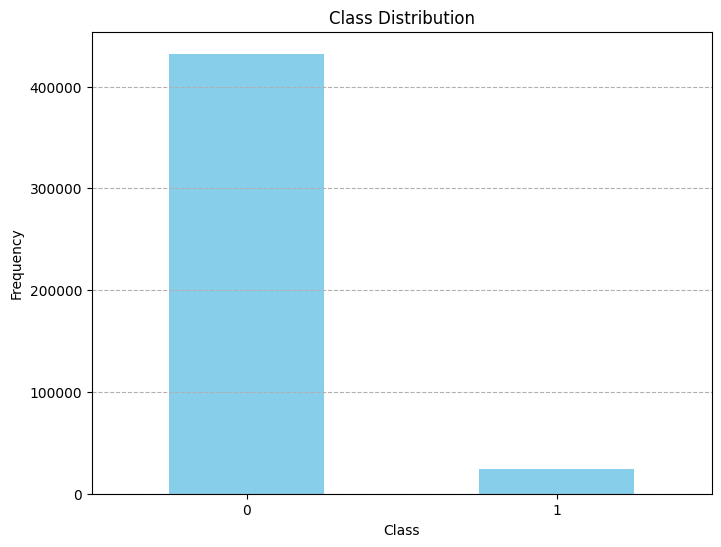

In [ ]:
# Đổi label của data, nhóm nợ 1-2 -> No Frauds, nhóm nợ 3->5: Frauds
fraud_dict = {
  '1': 0,
  '2': 0,
  '3': 1,
  '4': 1,
  '5': 1
}
cif_data['CIFMAX'] = cif_data['CIFMAX'].replace(fraud_dict)
customer_type_counts = cif_data['CIFMAX'].value_counts()
plt.figure(figsize=(8, 6))
customer_type_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# The classes are heavily skewed
print('No Frauds', round(cif_data['CIFMAX'].value_counts()[0]/len(cif_data) * 100,2), '% of the dataset')
print('Frauds', round(cif_data['CIFMAX'].value_counts()[1]/len(cif_data) * 100,2), '% of the dataset')

No Frauds 94.64 % of the dataset
Frauds 5.36 % of the dataset


Ngân hàng có tỷ lệ nợ xấu cao (5.36%) <p>
Ngoài ra, label của bộ dữ liệu có xu hướng bị lệch, ở phần sau sẽ sử dụng phương pháp upsampling sử dụng SMOTE để giải quyết vấn đề này

## 2.5. Chia bộ dataset ra thành 2 nhóm - KH cá nhân và KH doanh nghiệp

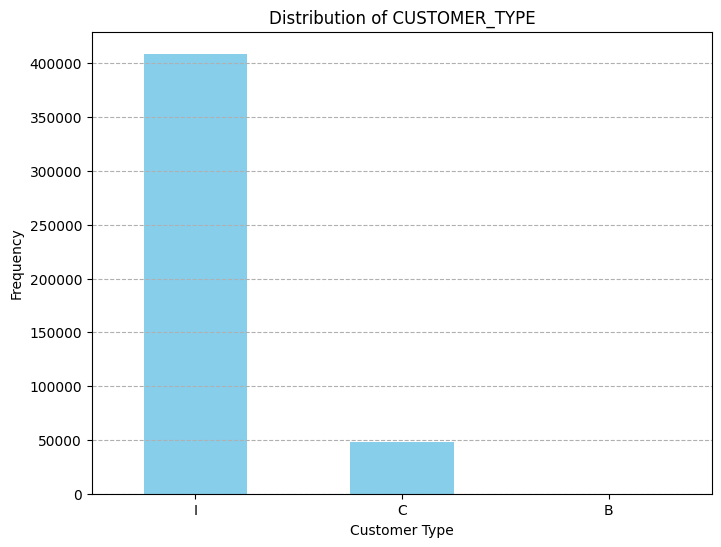

In [ ]:
# Check tỷ lệ khách hàng cá nhân và khách hàng doanh nghiệp
customer_type_counts = cif_data['CUSTOMER_TYPE'].value_counts()
plt.figure(figsize=(8, 6))
customer_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of CUSTOMER_TYPE')
plt.xlabel('Customer Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

Chia dataset thành 2 phần để tránh imbalanced data và vì khách hàng doanh nghiệp và khách hàng cá nhân có nhiều đặc điểm khác nhau về khuyến mãi, hành vi tiêu dùng, mục đích vay nên sẽ dựng mô hình chia thành 2 loại khách hàng khác nhau.

In [ ]:
individual_cif = cif_data[cif_data['CUSTOMER_TYPE']=='I']
individual_cif.reset_index(drop=True, inplace=True)
business_cif = cif_data[cif_data['CUSTOMER_TYPE'].isin(['C','B'])]
business_cif.reset_index(drop=True, inplace=True)

# 3. Xây dựng mô hình dự đoán rủi ro các khoản nợ

## 3.1. Khách hàng cá nhân

Những trường sử dụng:
1.   Nhóm chỉ tiêu về áp lực trả nợ
- Dư nợ
- Tỷ lệ nợ ngắn hạn trên tổng nợ (nợ dưới 1 năm): mức độ áp lực thanh khoản của khách hàng
- Dự thu tồn
- Lãi suất cho vay

2.   Nhóm chỉ tiêu về đặc tính cam kết của khách hàng
- Tài sản đảm bảo (Giá trị đảm bảo)
- Tỷ lệ nợ dài hạn trên tổng nợ (nợ trên 5 năm)

3. Mức độ quan hệ khách hàng
- Thông tin về số lượng sản phẩm nợ của khách hàng tại ngân hàng X (transactions)
- MIS_CODE (KH cá nhân & KH ưu tiên)

4. Nhóm chỉ tiêu về mức độ tín dụng của khách hàng
- CIC
- Dự phòng cụ thể  phải trích đến 31/12/2020
- ODIP

5. Nhóm chỉ tiêu về yếu tố ngoại cảnh
- LOANTYPE (COVID, NORM)
- Năm giải ngân

### 3.1.1. Chuẩn bị dữ liệu cho mô hình

Fill missing value cột MIS_CODE

In [ ]:
individual_cif['MIS_CODE'] = individual_cif['MIS_CODE'].astype(str)
individual_cif['MIS_CODE'].replace('nan', np.nan, inplace=True)

# Fill missing values with '100000' - KH cá nhân
individual_cif['MIS_CODE'].fillna('100000.0', inplace=True)
individual_cif['MIS_CODE'].replace('0.0', '100000.0', inplace=True)

Kiểm tra phân phối các label cho nhóm khách hàng cá nhân

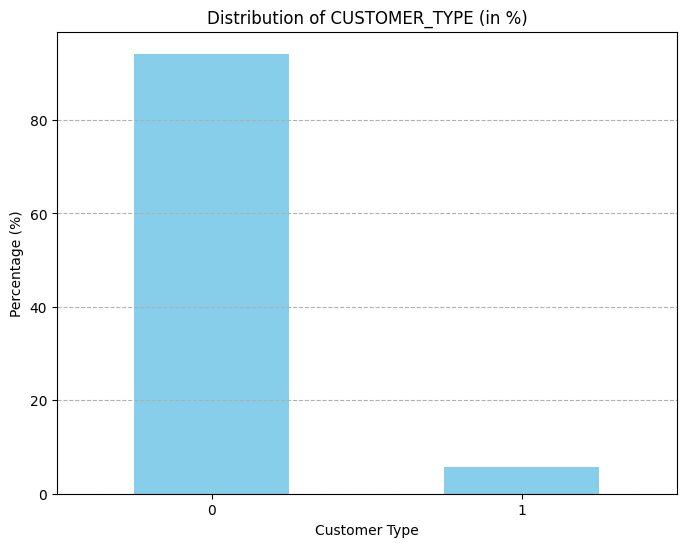

In [ ]:
customer_type_counts = individual_cif['CIFMAX'].value_counts()
customer_type_percentage = (customer_type_counts / customer_type_counts.sum()) * 100
plt.figure(figsize=(8, 6))
customer_type_percentage.plot(kind='bar', color='skyblue')
plt.title('Distribution of CUSTOMER_TYPE (in %)')
plt.xlabel('Customer Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

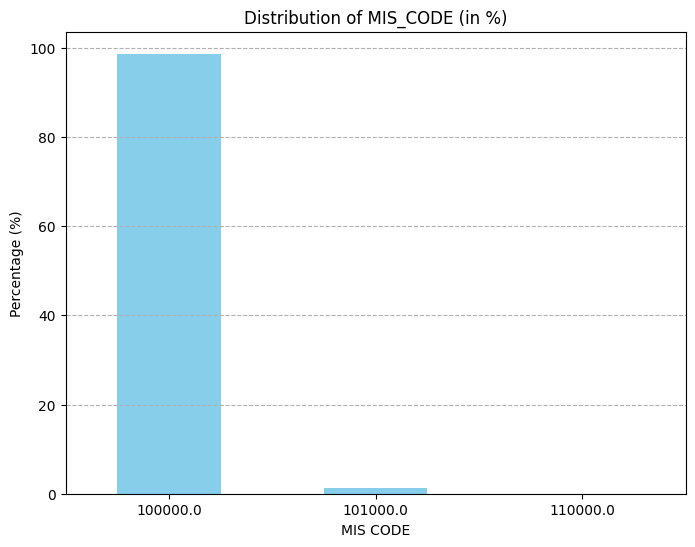

In [ ]:
customer_type_counts = individual_cif['MIS_CODE'].value_counts()
customer_type_percentage = (customer_type_counts / customer_type_counts.sum()) * 100
plt.figure(figsize=(8, 6))
customer_type_percentage.plot(kind='bar', color='skyblue')
plt.title('Distribution of MIS_CODE (in %)')
plt.xlabel('MIS CODE')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

Tỷ lệ khách hàng ưu tiên chiếm 1.35%

### 3.1.2. Tương quan các biến

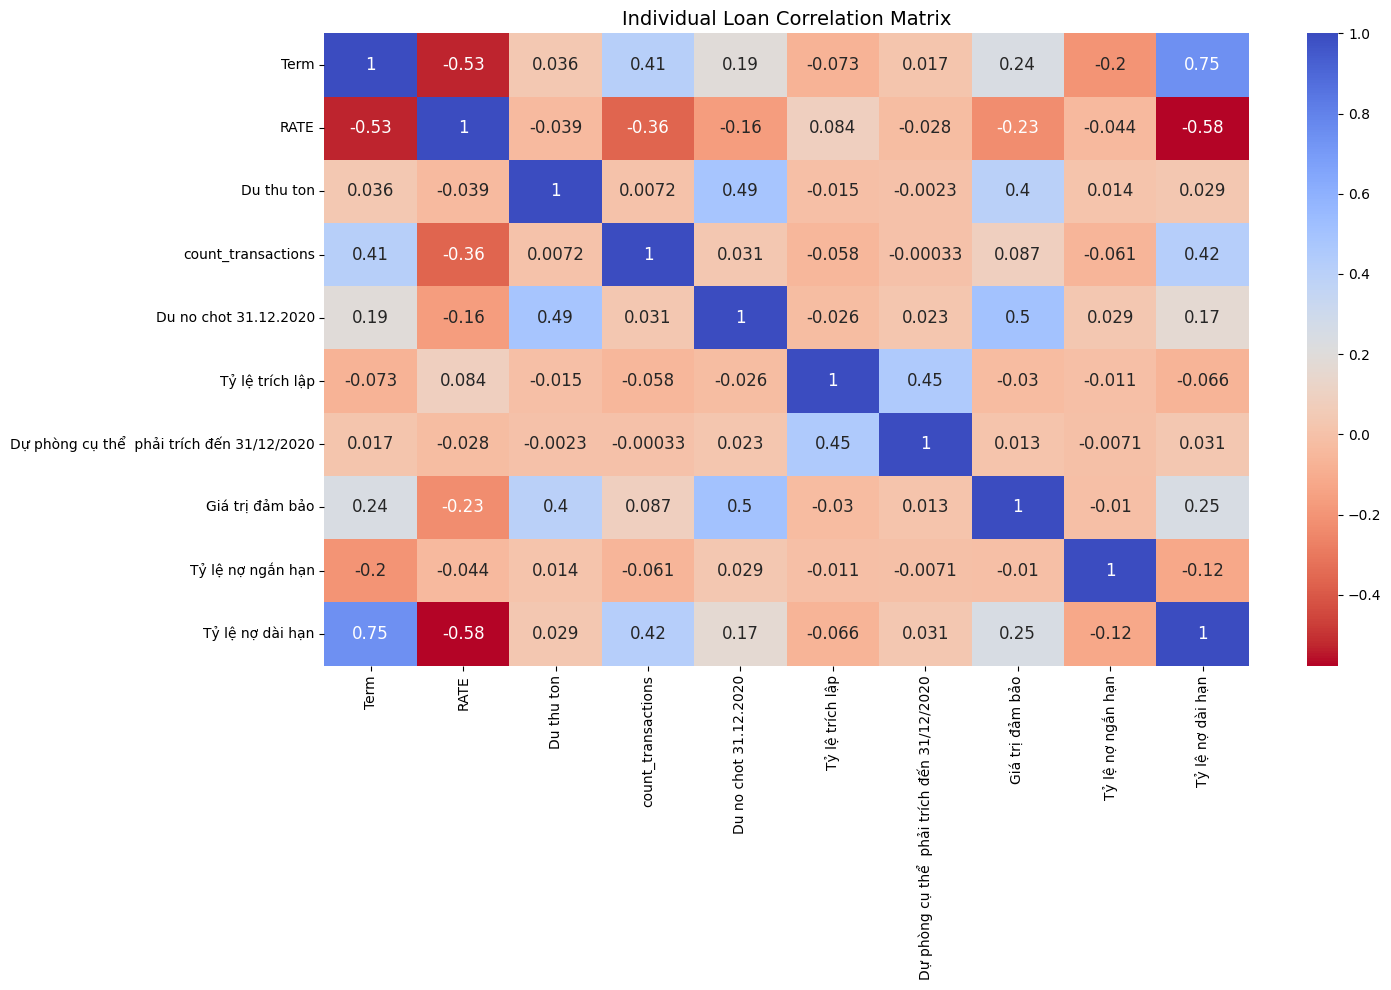

In [ ]:
plt.figure(figsize=(15, 10))

# Tạo ma trận tương quan
num = individual_cif.select_dtypes(include=['number']).corr()

# Loại bỏ các trường không sử dụng
corr = num.drop(columns=['LCY_CURR_BALANCE', 'CIFMAX', 'INT RECAL', 'CARDMAX', 'Dư nợ tính dự phòng'])
corr = corr.drop(index=['LCY_CURR_BALANCE', 'CIFMAX', 'INT RECAL', 'CARDMAX', 'Dư nợ tính dự phòng'])
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':12})
plt.title("Individual Loan Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()


Phần lớn các trường trong bộ dữ liệu có tương quan thấp nên không ảnh hưởng nhiều tới vấn đề tự tương quan của mô hình. Một số cặp có tương quan lớn hơn 0.5 có thể kể đến là:
- Tỷ lệ nợ dài hạn và Term (kỳ hạn khoản vay)
- Term và Rate (-0.53): các khoản vay có kỳ hạn dài thì lãi suất thường thấp hơn
- Rate và tỷ lệ nợ dài hạn (-0.58): các khoản vay có lãi suất cao thì thường là những khoản vay ngắn hạn
- Dư nợ chốt 31.12.2020 và Giá trị đảm bảo (0.5): các khoản nợ còn dư nợ cao thì lượng TSĐB cũng cao

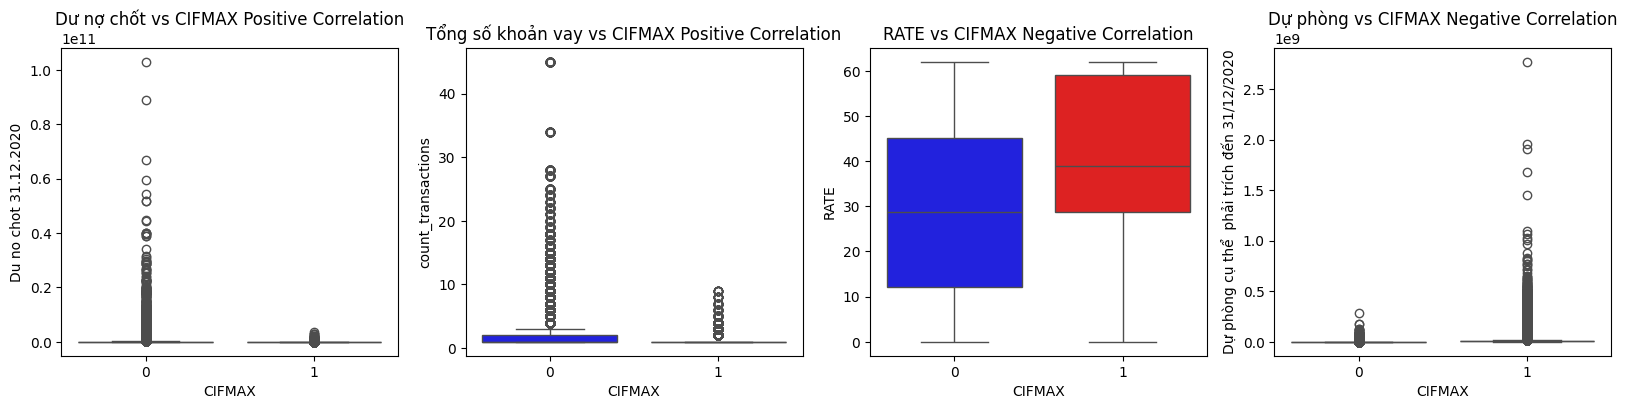

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['#0303fc', '#fc0303']

sns.boxplot(x="CIFMAX", y="Du no chot 31.12.2020", data=individual_cif, palette=colors, ax=axes[0])
axes[0].set_title('Dư nợ chốt vs CIFMAX Positive Correlation')

sns.boxplot(x="CIFMAX", y="count_transactions", data=individual_cif, palette=colors, ax=axes[1])
axes[1].set_title('Tổng số khoản vay vs CIFMAX Positive Correlation')


sns.boxplot(x="CIFMAX", y="RATE", data=individual_cif, palette=colors, ax=axes[2])
axes[2].set_title('RATE vs CIFMAX Negative Correlation')


sns.boxplot(x="CIFMAX", y="Dự phòng cụ thể  phải trích đến 31/12/2020", data=individual_cif, palette=colors, ax=axes[3])
axes[3].set_title('Dự phòng vs CIFMAX Negative Correlation')

plt.show()

Có thể thấy các trường dữ liệu có tương quan khác nhau tại các phân khúc khách hàng
- Tổng dư nợ càng cao thì xác suất fraud càng giảm
- Tổng số khoản vay càng cao thì xác suất fraud càng giảm
- Lãi suất càng cao thì xác suất fraud càng tăng
- Dự phòng cụ thể phải trích đến 31/12/2020 càng cao thì xác suất fraud càng tăng
<P>Ngoài ra, có thể quan sát được rằng các biến đều đang có nhiều dữ liệu ngoại lai. Và việc xử lý được lượng dữ liệu ngoại lai này sẽ giúp cho mô hình trở nên chính xác hơn.

### 3.1.3. Phân phối của các biến với từng nhóm khách hàng

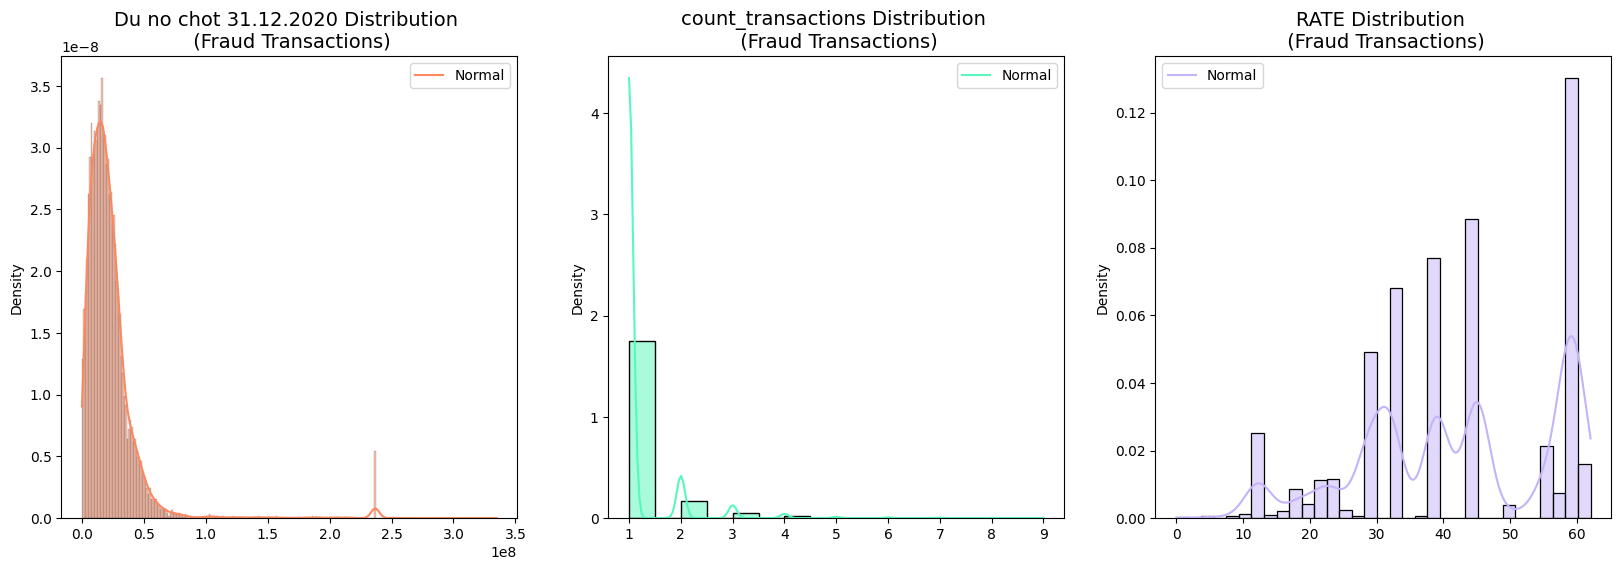

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = individual_cif['Du no chot 31.12.2020'].loc[individual_cif['CIFMAX'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861', line_kws={'label': 'Normal'})
ax1.set_title('Du no chot 31.12.2020 Distribution \n (Fraud Transactions)', fontsize=14)
ax1.legend()

v12_fraud_dist = individual_cif['count_transactions'].loc[individual_cif['CIFMAX'] == 1].values
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB', line_kws={'label': 'Normal'})
ax2.set_title('count_transactions Distribution \n (Fraud Transactions)', fontsize=14)
ax2.legend()

v10_fraud_dist = individual_cif['RATE'].loc[individual_cif['CIFMAX'] == 1].values
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, stat="density", color='#C5B3F9', line_kws={'label': 'Normal'})
ax3.set_title('RATE Distribution \n (Fraud Transactions)', fontsize=14)
ax3.legend()

plt.show()


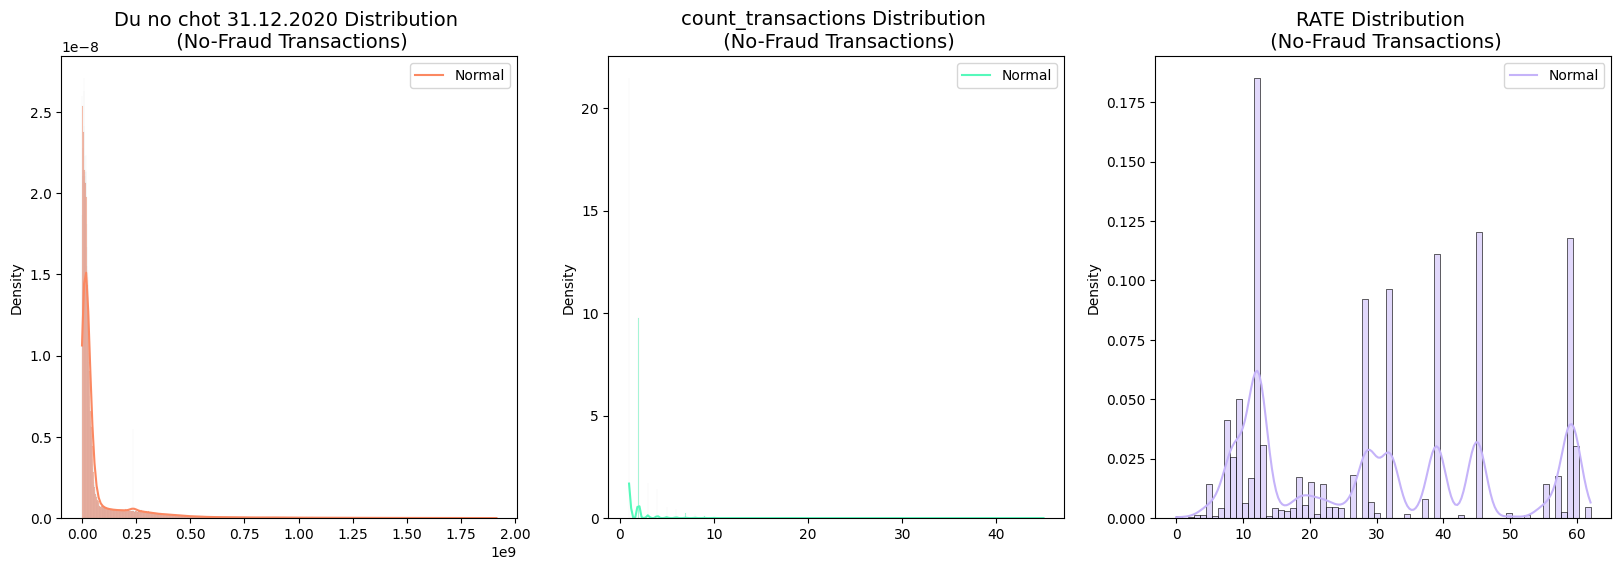

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = individual_cif['Du no chot 31.12.2020'].loc[individual_cif['CIFMAX'] == 0].values
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861', line_kws={'label': 'Normal'})
ax1.set_title('Du no chot 31.12.2020 Distribution \n (No-Fraud Transactions)', fontsize=14)
ax1.legend()

v12_fraud_dist = individual_cif['count_transactions'].loc[individual_cif['CIFMAX'] == 0].values
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB', line_kws={'label': 'Normal'})
ax2.set_title('count_transactions Distribution \n (No-Fraud Transactions)', fontsize=14)
ax2.legend()

v10_fraud_dist = individual_cif['RATE'].loc[individual_cif['CIFMAX'] == 0].values
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, stat="density", color='#C5B3F9', line_kws={'label': 'Normal'})
ax3.set_title('RATE Distribution \n (No-Fraud Transactions)', fontsize=14)
ax3.legend()

plt.show()


So sánh 2 nhóm khách hàng, có thể thấy được những điểm khác biệt giữa 2 nhóm như:
- Về lượng dư nợ, nhóm No-Default có phân phối rộng hơn nhóm Default nhưng lại tập trung nhiều hơn ở khoảng những giá trị nhỏ
- Về số lượng khoản vay của khách hàng, nhóm No-Default có lượng giao dịch nhìn chung cao hơn so với nhóm Default
- Về lãi suất, trong khi các khoản vay của nhóm No-Default tập trung nhiều ở khoảng 8%-14% thì phần lãi suất ở các khoản vay Default tập trung nhiều nhất ở ngưỡng 54%-62%. Vì vậy, đây sẽ là một metric rất quan trọng trong việc phân khúc khách hàng và đề xuất được mức rủi ro hợp lý cho ngân hàng.

### 3.1.3. Xử lý outlier

In [ ]:
# Remove outlier bằng phương pháp 3 sigma
def remove_outliers(df, column_name):
    """
    Loại bỏ outlier theo phương pháp 3-sigma cho cột được chỉ định.

    Parameters:
    df (DataFrame): DataFrame chứa dữ liệu cần xử lý.
    column_name (str): Tên của cột cần loại bỏ outlier.

    Returns:
    DataFrame: DataFrame sau khi đã loại bỏ các outlier.
    """
    # Tính giá trị trung bình và độ lệch chuẩn của cột
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    initial_count = df.shape[0]

    # Xác định ngưỡng loại bỏ outlier theo phương pháp 3-sigma
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value

    # Loại bỏ các outlier và trả về DataFrame mới
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    df.reset_index(drop=True, inplace=True)
    final_count = df.shape[0]

    # Tính số lượng dòng đã bị xóa
    rows_removed = initial_count - final_count
    print(f"Số dòng đã bị xóa: {rows_removed}")
    return df

In [ ]:
individual_cif = remove_outliers(individual_cif, 'Du no chot 31.12.2020')

Số dòng đã bị xóa: 2466


In [ ]:
individual_cif = remove_outliers(individual_cif, 'Dự phòng cụ thể  phải trích đến 31/12/2020')

Số dòng đã bị xóa: 1230


In [ ]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))
    data_series = data[measure]
    (mu, sigma) = norm.fit(data_series)

    # Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.histplot(data_series, kde=True, stat="density", linewidth=0, label="Data")
    sns.lineplot(x=fig1.get_lines()[0].get_data()[0], y=norm.pdf(fig1.get_lines()[0].get_data()[0], mu, sigma), color="red", label="Normal Fit")
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Density')
    fig1.legend()

    # QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data_series, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data_series.skew(), data_series.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

In [ ]:
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0],color='#A1C9F1')
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1],color='#A1C9F1')
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='#5586B0', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),2)) + symb)
    plt.axvline(df[col].median(), color='#B12051', linewidth=2.2, label='median='+ str(np.round(df[col].median(),2)) + symb)
    plt.axvline(df[col].mode()[0], color='#011F82', linewidth=2.2, label='mode='+ str(df[col].mode()[0]) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=16,fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()

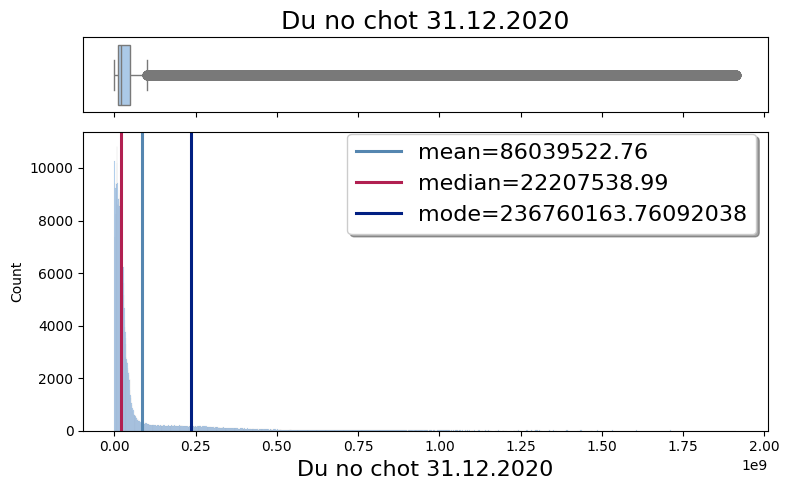

In [ ]:
num_plot(individual_cif, 'Du no chot 31.12.2020', 'Du no chot 31.12.2020', '')

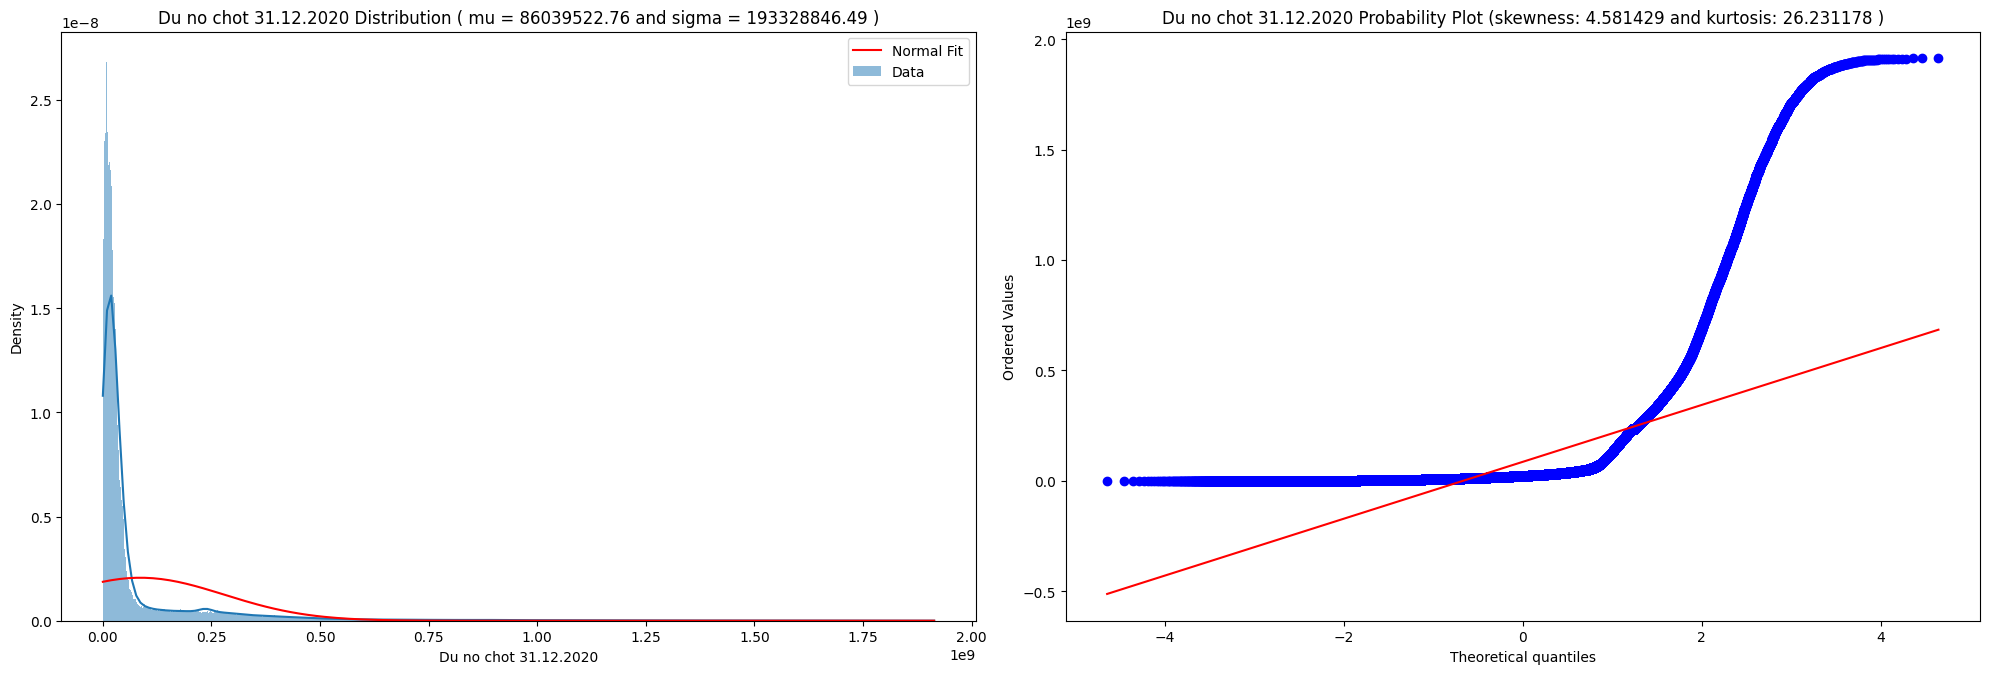

In [ ]:
QQ_plot(individual_cif, 'Du no chot 31.12.2020')

Có thể thấy số lượng outlier đã giảm đáng kể sau khi sử dụng phương pháp 3 sigma. Tuy nhiên, 2 chỉ số về skewness và kurtosis vẫn rất cao:
- Skewness = 4.58
- Kurtosis = 26.23
<p> Để giải quyết vấn đề này, nhóm sẽ lấy logarit tự nhiên của biến để tăng sự chính xác của mô hình.

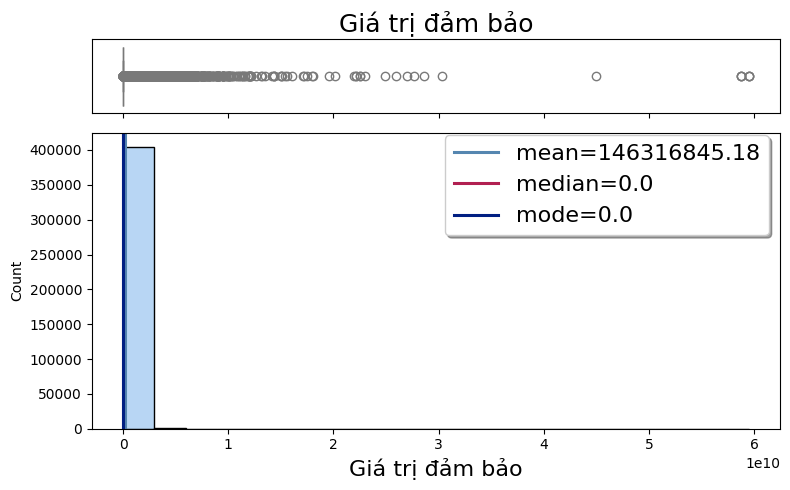

In [ ]:
num_plot(individual_cif, 'Giá trị đảm bảo', 'Giá trị đảm bảo', '')

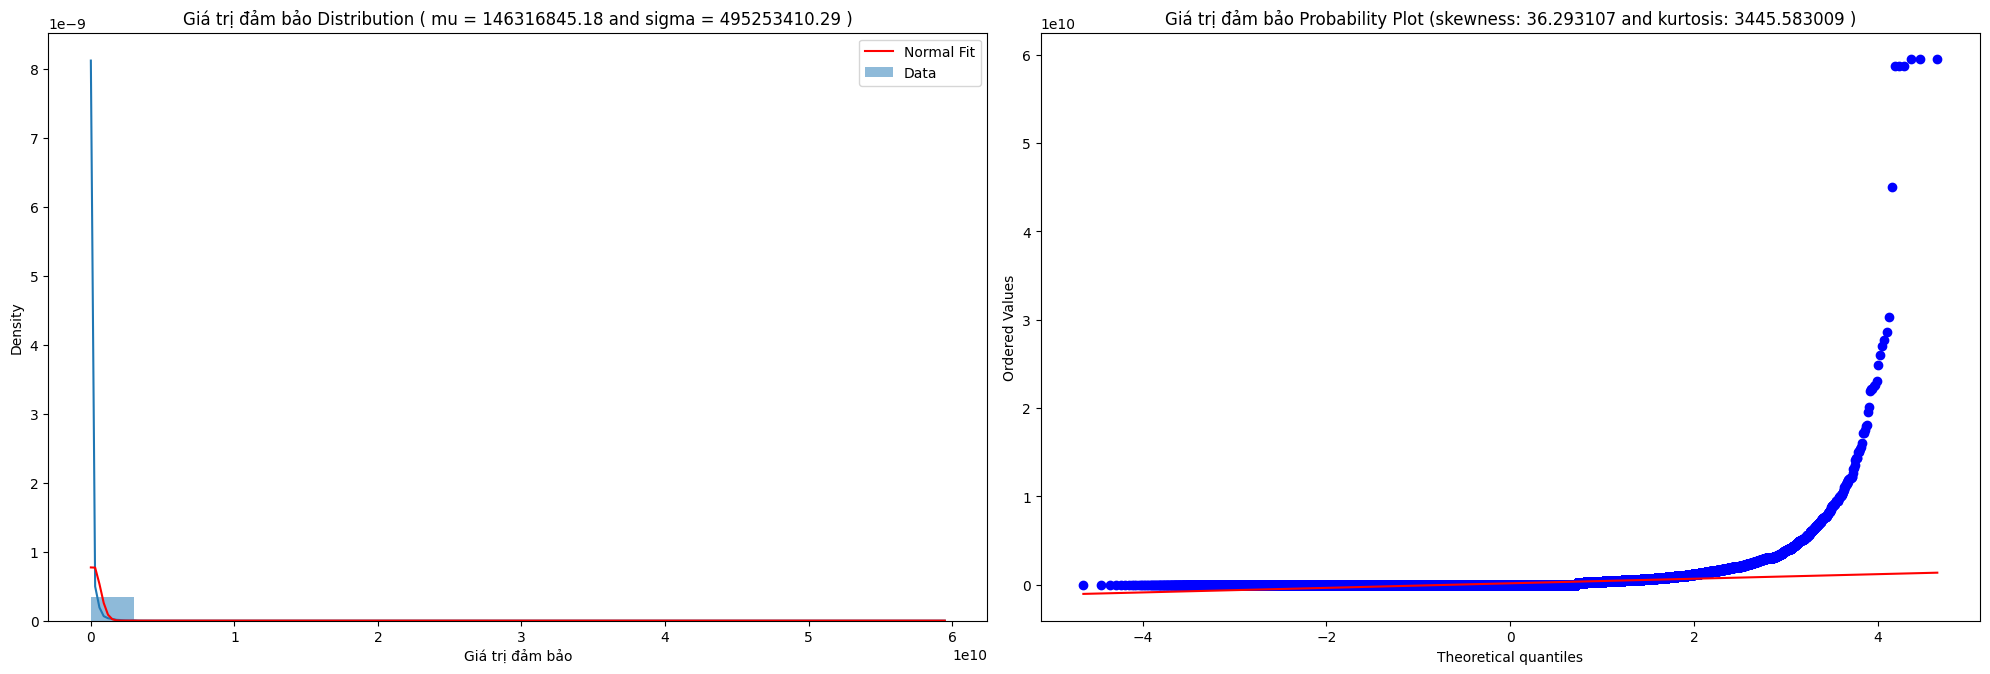

In [ ]:
QQ_plot(individual_cif, 'Giá trị đảm bảo')

Mặc dù trường `Giá trị đảm bảo` cũng có nhiều outlier nhưng nguyên do có thể đến từ phần lớn các khoản vay không có TSĐB nên nhóm sẽ không xóa đi những outlier của trường này nhằm giữ lại sự khác biệt giữa các khoản vay có và không có TSĐB. Đối với các trường này, nhóm sẽ sử dụng RobustScaler để giảm tác động của những outlier tới mô hình.

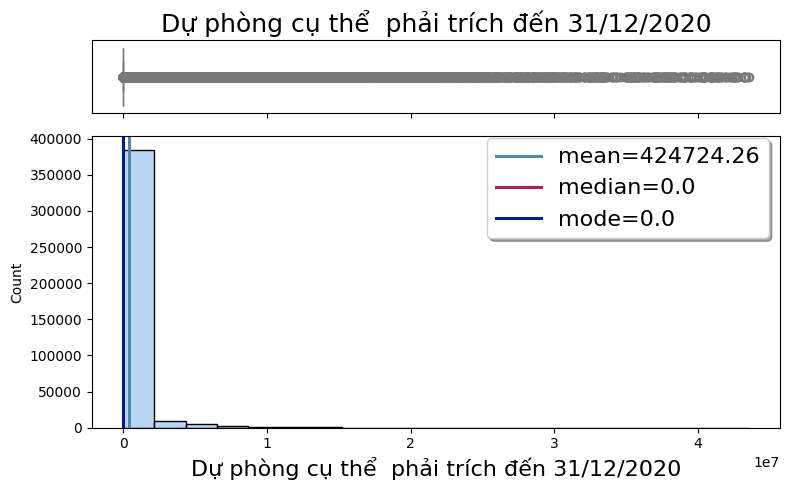

In [ ]:
num_plot(individual_cif, 'Dự phòng cụ thể  phải trích đến 31/12/2020', 'Dự phòng cụ thể  phải trích đến 31/12/2020', '')

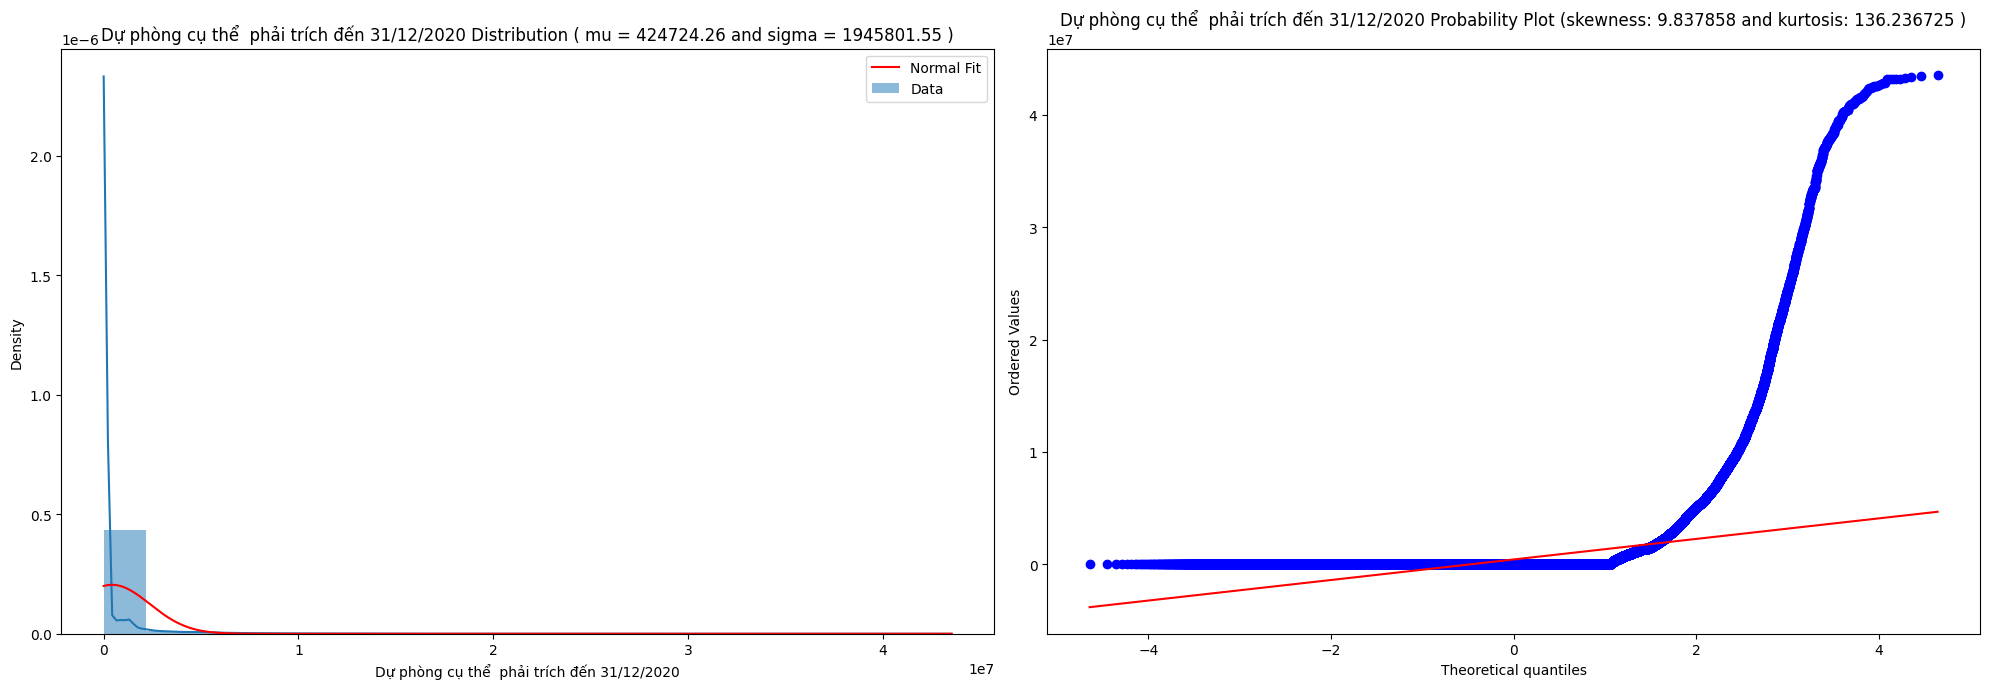

In [ ]:
QQ_plot(individual_cif, 'Dự phòng cụ thể  phải trích đến 31/12/2020')

Tương tự như trường dư nợ chốt, sau khi xóa đi outlier thì dữ liệu vẫn có skewness và kurtosis cao nên nhóm sẽ lấy logarit tự nhiên của biến này

### 3.1.4. Tiền xử lý dữ liệu

Ở bước này, nhóm sẽ lấy logarit tự nhiên của các trường đã loại bỏ outlier nhưng vẫn có hai chỉ số về skewness và kurtosis cao. Đối với các trường có nhiều outlier nhưng nhóm quyết định giữ lại sẽ được áp dụng Robust Scaler để giảm tác động của các yếu tố ngoại lai tới mô hình.
<p> Sau đó, các biến category sẽ được mã hóa bằng One Hot Encoder trước khi đưa vào mô hình.
<p> Cuối cùng, nhóm sử dụng kỹ thuật upsampling để làm cân bằng 2 label, tránh cho dữ liệu bị bias.

In [ ]:
# Lấy logarit tự nhiên cho 2 trường có skewness của kurtosis cao sat khi loại bỏ outlier
individual_cif['lnDu_no_chot'] = np.log(individual_cif['Du no chot 31.12.2020'])
individual_cif['lnDu_phong_chot'] = np.log(individual_cif['Dự phòng cụ thể  phải trích đến 31/12/2020'])
individual_cif['lnDu_phong_chot'].replace(-np.inf, 0, inplace=True)

In [ ]:
# Áp dụng Robust Scaler cho các trường có nhiều outlier nhưng không muốn loại bỏ
scaler = RobustScaler()
individual_cif[['Giá trị đảm bảo', 'Du thu ton']] = scaler.fit_transform(individual_cif[['Giá trị đảm bảo', 'Du thu ton']])

In [ ]:
X = individual_cif[['MIS_CODE', 'RATE', 'Du thu ton', 'LOANTYPE', 'CIC', 'ODIP', 'CARD', 'count_transactions', 'lnDu_no_chot',
                    'lnDu_phong_chot', 'Giá trị đảm bảo', 'Năm giải ngân', 'Tỷ lệ nợ ngắn hạn', 'Tỷ lệ nợ dài hạn']]
y = individual_cif['CIFMAX']
categorical_columns = X.select_dtypes(include=['object']).columns
# Tạo một transformer để one-hot encode các cột chuỗi
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Giữ lại các cột số không bị chuyển đổi
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Áp dụng SMOTE cho dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Original dataset shape: {pd.Series(y_train).value_counts()}")
print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")

Original dataset shape: CIFMAX
0    306030
1     18190
Name: count, dtype: int64
Resampled dataset shape: CIFMAX
0    306030
1    306030
Name: count, dtype: int64


### 3.1.5. Xây dựng mô hình machine learning để phân loại khách hàng

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier()
}

In [ ]:
for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X_resampled, y_resampled, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 5) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 66.90899999999999 % accuracy score
Classifiers:  RandomForestClassifier has a training score of 99.97200000000001 % accuracy score
Classifiers:  AdaBoostClassifier has a training score of 99.677 % accuracy score
Classifiers:  XGBClassifier has a training score of 99.97 % accuracy score


Có thể thấy, chỉ số accuracy của các mô hình sử dụng ensemble method (sử dụng nhiều mô hình để dự đoán) cao hơn so với các mô hình đơn giản hơn như hồi quy logistic. Tuy nhiên, đây cũng có thể do lỗi overfitting, khi mô hình quá phức tạp so với bộ dữ liệu. Để kiểm tra điều này, nhóm lựa chọn mô hình Random Forest để theo dõi kỹ hơn.

### 3.1.6. Kiểm tra lỗi overfitting của mô hình

Tiếp theo, nhóm thực hiện kiểm tra overfitting của mô hình đối với bộ dữ liệu

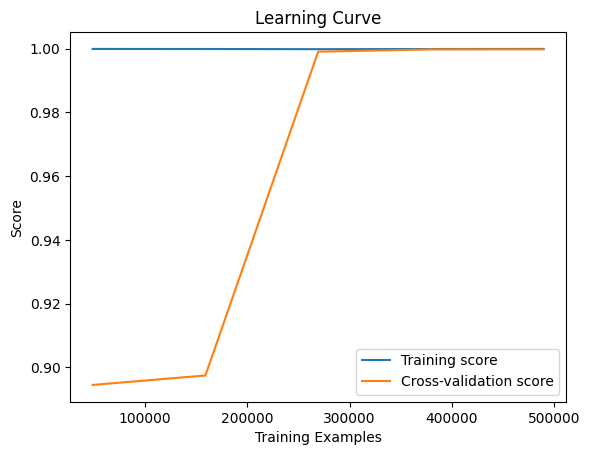

In [ ]:
# Tính toán và vẽ đồ thị learning curve
random_forest = RandomForestClassifier(random_state=42)
train_sizes, train_scores, test_scores = learning_curve(random_forest, X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")

plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()


Mô hình bị overfitting vì accuracy ở tập train cao, xấp xỉ bằng 1; trong khi đó chỉ số này ở tập test nhỏ hơn rất nhiều, chỉ tăng dần sau khi tăng đến mức dữ liệu lớn hơn. Để khắc phục trường hợp này, nhóm thực hiện điều chỉnh các hyperparameters của mô hình nhằm tránh trường hợp overfitting

In [ ]:
random_forest = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42
)

random_forest.fit(X_resampled, y_resampled)
y_pred = random_forest.predict(X_test_preprocessed)

# Tính toán accuracy, recall, precision, và F1 score cho bộ dữ liệu kiểm tra
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred, average='weighted')
test_precision = precision_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Random Forest Classifier has a test accuracy score of {round(test_accuracy * 100, 2)}%")
print(f"Recall: {round(test_recall * 100, 2)}%")
print(f"Precision: {round(test_precision * 100, 2)}%")
print(f"F1 Score: {round(test_f1 * 100, 2)}%")


Random Forest Classifier has a test accuracy score of 95.15%
Recall: 95.15%
Precision: 97.43%
F1 Score: 95.83%


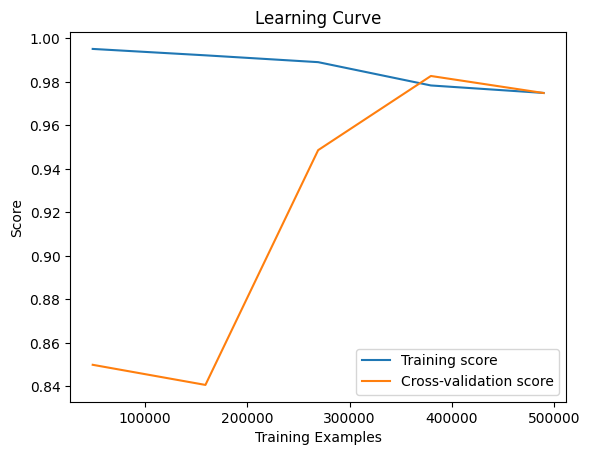

In [ ]:
# Tạo learning curve
train_sizes, train_scores, test_scores = learning_curve(random_forest, X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")

plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()


Như vậy, tình trạng overfitting của bộ dữ liệu đã giảm đáng kể.

### 3.1.7. Lựa chọn metric đánh giá mô hình

Trong bài toán phân loại, **Confusion Matrix** là công cụ hữu ích để hình dung hiệu suất của mô hình. Confusion Matrix bao gồm 4 chỉ số quan trọng:

- **True Negatives (TN)**: Số lượng mẫu thuộc lớp "Không" (Không phát hiện gian lận) được mô hình phân loại đúng.
- **False Negatives (FN)**: Số lượng mẫu thuộc lớp "Không" nhưng mô hình phân loại sai là "Có" (Phát hiện gian lận).
- **False Positives (FP)**: Số lượng mẫu thuộc lớp "Có" nhưng mô hình phân loại sai là "Không".
- **True Positives (TP)**: Số lượng mẫu thuộc lớp "Có" được mô hình phân loại đúng.

![Confusion Matrix](selvaraj_confusion_matrix_precision_recall_explained_12.png)

#### Metrics Đánh Giá

- **Accuracy**: Tỷ lệ phần trăm của các dự đoán đúng trên tổng số dự đoán.

- **Precision**: Tỷ lệ phần trăm các dự đoán "Có" (Phát hiện gian lận) đúng trên tổng số các dự đoán "Có".

- **Recall**: Tỷ lệ phần trăm các trường hợp thực sự "Có" (Phát hiện gian lận) được mô hình phát hiện đúng trên tổng số các trường hợp thực sự "Có".

#### Lý Do Chọn **Recall** cho Bài Toán Phân Loại Khách Hàng Gian Lận

Trong bài toán phát hiện khách hàng gian lận, **Recall** là chỉ số quan trọng nhất vì nó đo lường khả năng mô hình phát hiện tất cả các trường hợp gian lận thực sự. Việc bỏ sót (FN) một khách hàng gian lận có thể gây ra hậu quả nghiêm trọng hơn nhiều so với việc báo động sai (FP). Do đó, tối ưu hóa **Recall** giúp đảm bảo rằng mô hình có thể phát hiện được càng nhiều trường hợp gian lận càng tốt, giảm thiểu rủi ro cho doanh nghiệp.

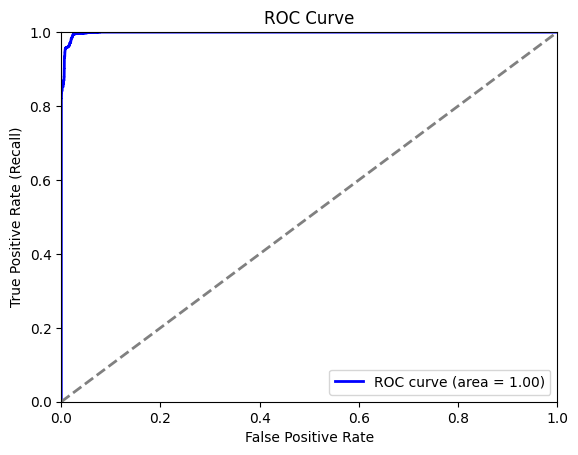

In [ ]:
# Vẽ ROC Curve
y_prob = random_forest.predict_proba(X_test_preprocessed)[:, 1]

# Tính FPR và TPR cho các ngưỡng khác nhau
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Tính toán diện tích dưới đường cong (AUC)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:

random_forest = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42
)

random_forest.fit(X_resampled, y_resampled)
y_prob = random_forest.predict_proba(X_test_preprocessed)

# Thay đổi ngưỡng thành 0.3 để tăng recall
threshold = 0.7
y_pred_adjusted = (y_prob[:, 1] >= threshold).astype(int)

# Tính toán accuracy, recall, precision, và F1 score cho bộ dữ liệu kiểm tra với ngưỡng mới
test_accuracy = accuracy_score(y_test, y_pred_adjusted)
test_recall = recall_score(y_test, y_pred_adjusted, average='weighted')
test_precision = precision_score(y_test, y_pred_adjusted, average='weighted')
test_f1 = f1_score(y_test, y_pred_adjusted, average='weighted')

print(f"Random Forest Classifier with adjusted threshold {threshold}:")
print(f"Test Accuracy: {round(test_accuracy * 100, 2)}%")
print(f"Recall: {round(test_recall * 100, 2)}%")
print(f"Precision: {round(test_precision * 100, 2)}%")
print(f"F1 Score: {round(test_f1 * 100, 2)}%")


Random Forest Classifier with adjusted threshold 0.7:
Test Accuracy: 97.87%
Recall: 97.87%
Precision: 98.42%
F1 Score: 98.02%


In [ ]:
explainer = shap.Explainer(random_forest.predict_proba, X_test_preprocessed)
shap_values = explainer(X_test_preprocessed)
shap.plots.waterfall(shap_values[0])

PermutationExplainer explainer:   2%|▏         | 1796/81055 [02:38<1:51:02, 11.90it/s]

# Khách hàng doanh nghiệp

Tương tự với nhóm khách hàng cá nhân, các metrics được lựa chọn để phân loại nhóm khách hàng doanh nghiệp là:
Những trường sử dụng:
1.   Nhóm chỉ tiêu về áp lực trả nợ
- Dư nợ
- Tỷ lệ nợ ngắn hạn trên tổng nợ (nợ dưới 1 năm): mức độ áp lực thanh khoản của khách hàng
- Dự thu tồn
- Lãi suất cho vay

2.   Nhóm chỉ tiêu về đặc tính cam kết của khách hàng
- Tài sản đảm bảo (Giá trị đảm bảo)
- Tỷ lệ nợ dài hạn trên tổng nợ (nợ trên 5 năm)

3. Mức độ quan hệ khách hàng
- Thông tin về số lượng sản phẩm nợ của khách hàng tại ngân hàng X (transactions)
- MIS_CODE

4. Nhóm chỉ tiêu về mức độ tín dụng của khách hàng
- CIC
- Dự phòng cụ thể  phải trích đến 31/12/2020
- ODIP

5. Nhóm chỉ tiêu về yếu tố ngoại cảnh
- LOANTYPE (COVID, NORM)
- Năm giải ngân
> Ngoài các trường này, nhóm bổ sung thêm 1 chỉ số về tình trạng của ngành trong bối cảnh COVID-19

Ở phần này, nhóm thực hiện dựng mô hình tương tự với phần khách hàng cá nhân

In [ ]:
replacement_dict = {
    '101': '2',
    '201': '2',
    '202': '2',
    '203': '2',
    '204': '0',
    '301': '2',
    '401': '2',
    '402': '2',
    '403': '2',
    '501': '1',
    '601': '2',
    '602': '2',
    '701': '1',
    '702': '2',
    '801': '0',
    '802': '2',
    '803': '1',
    '804': '2',
    '805': '2',
    '807': '0'
}
business_cif['INDUSTRY_SITUATION'] = business_cif['INDUSTRY_CODE'].replace(replacement_dict)

<ipython-input-21-6db27c7725a9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_cif['INDUSTRY_SITUATION'] = business_cif['INDUSTRY_CODE'].replace(replacement_dict)


In [ ]:
business_cif = business_cif[business_cif['MIS_CODE'] != 'nan']

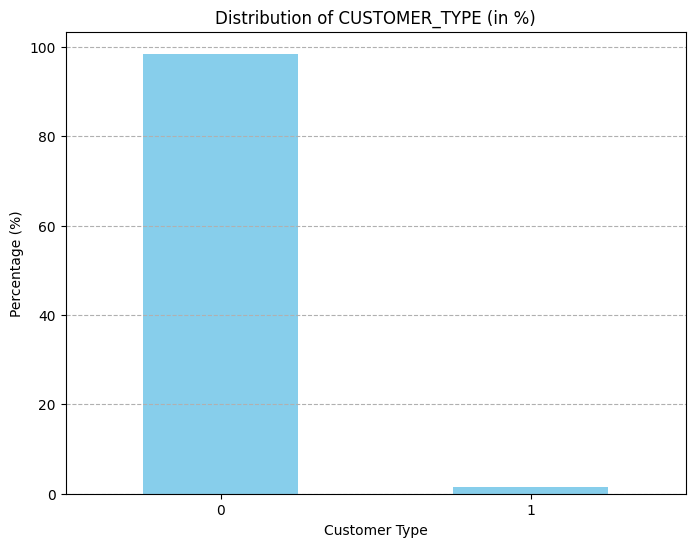

In [ ]:
customer_type_counts = business_cif['CIFMAX'].value_counts()
customer_type_percentage = (customer_type_counts / customer_type_counts.sum()) * 100
plt.figure(figsize=(8, 6))
customer_type_percentage.plot(kind='bar', color='skyblue')
plt.title('Distribution of CUSTOMER_TYPE (in %)')
plt.xlabel('Customer Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

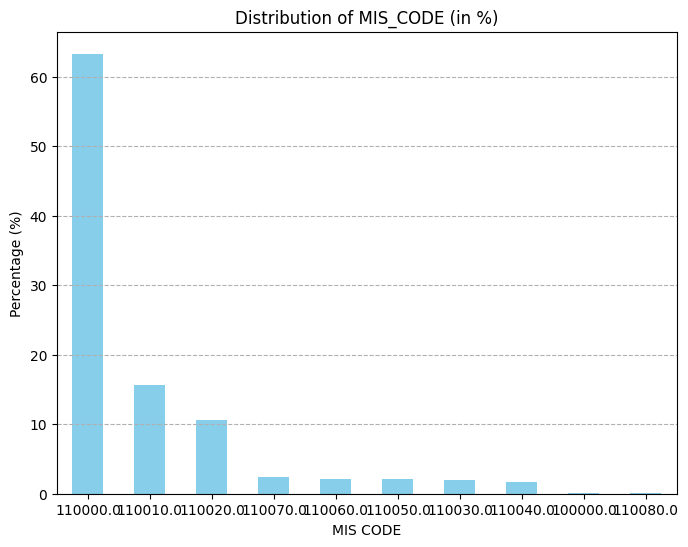

In [ ]:
customer_type_counts = business_cif['MIS_CODE'].value_counts()
customer_type_percentage = (customer_type_counts / customer_type_counts.sum()) * 100
plt.figure(figsize=(8, 6))
customer_type_percentage.plot(kind='bar', color='skyblue')
plt.title('Distribution of MIS_CODE (in %)')
plt.xlabel('MIS CODE')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

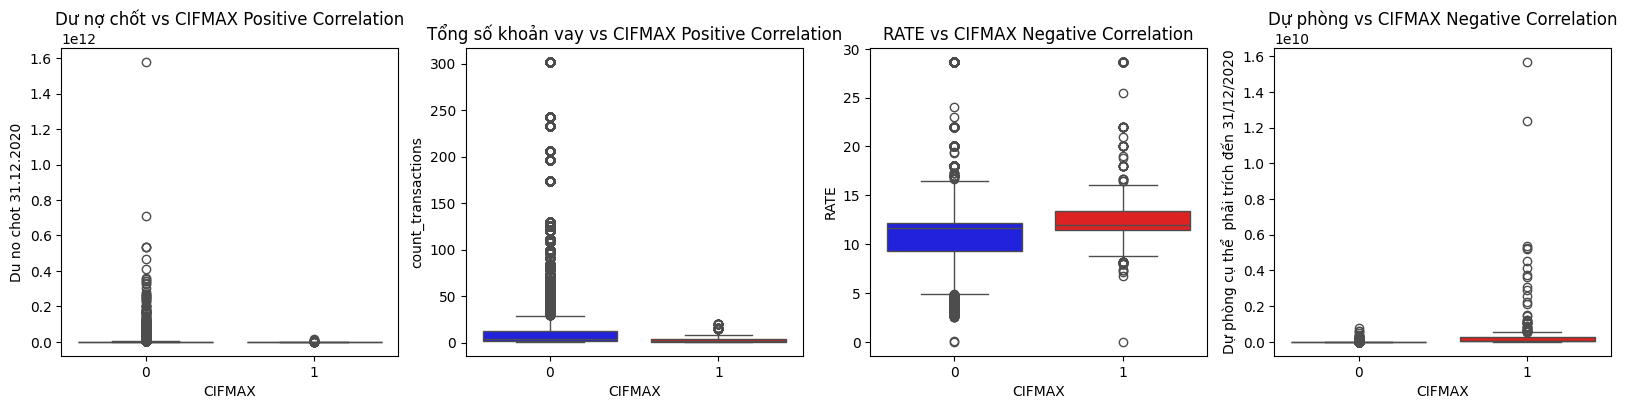

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['#0303fc', '#fc0303']

sns.boxplot(x="CIFMAX", y="Du no chot 31.12.2020", data=business_cif, palette=colors, ax=axes[0])
axes[0].set_title('Dư nợ chốt vs CIFMAX Positive Correlation')

sns.boxplot(x="CIFMAX", y="count_transactions", data=business_cif, palette=colors, ax=axes[1])
axes[1].set_title('Tổng số khoản vay vs CIFMAX Positive Correlation')


sns.boxplot(x="CIFMAX", y="RATE", data=business_cif, palette=colors, ax=axes[2])
axes[2].set_title('RATE vs CIFMAX Negative Correlation')


sns.boxplot(x="CIFMAX", y="Dự phòng cụ thể  phải trích đến 31/12/2020", data=business_cif, palette=colors, ax=axes[3])
axes[3].set_title('Dự phòng vs CIFMAX Negative Correlation')

plt.show()

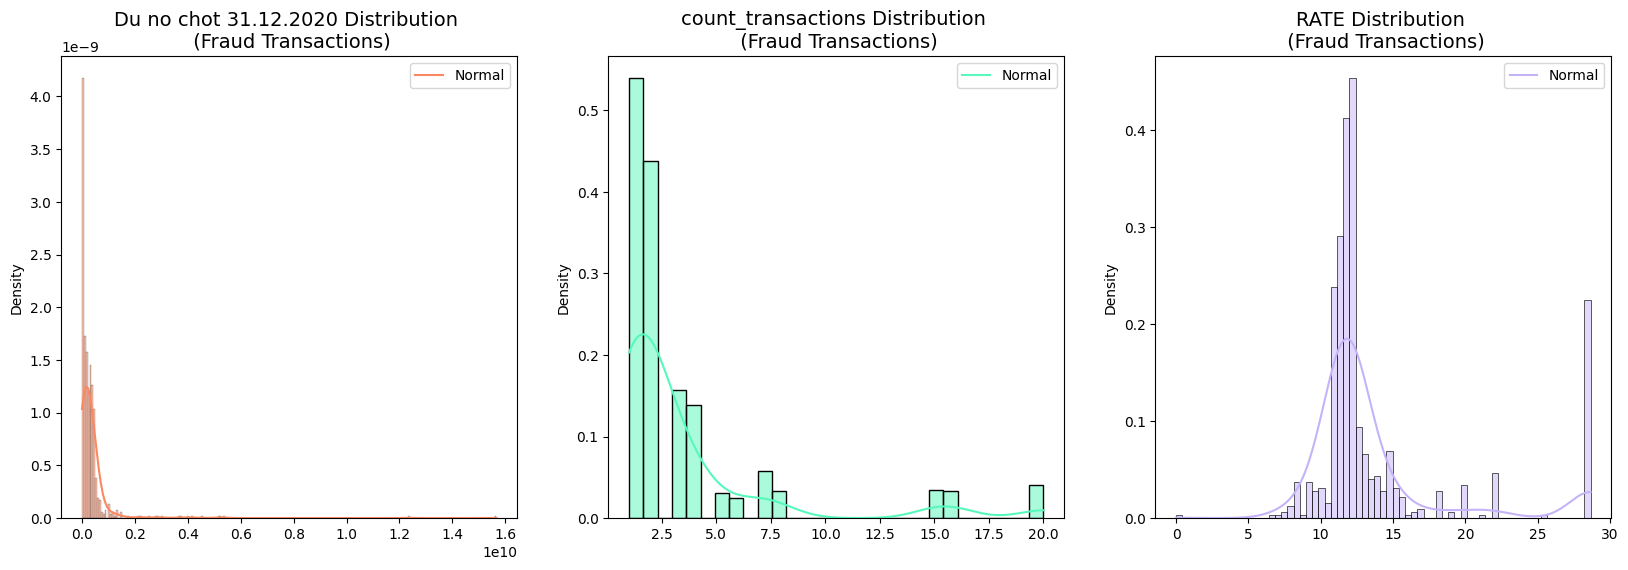

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = business_cif['Du no chot 31.12.2020'].loc[business_cif['CIFMAX'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861', line_kws={'label': 'Normal'})
ax1.set_title('Du no chot 31.12.2020 Distribution \n (Fraud Transactions)', fontsize=14)
ax1.legend()

v12_fraud_dist = business_cif['count_transactions'].loc[business_cif['CIFMAX'] == 1].values
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB', line_kws={'label': 'Normal'})
ax2.set_title('count_transactions Distribution \n (Fraud Transactions)', fontsize=14)
ax2.legend()

v10_fraud_dist = business_cif['RATE'].loc[business_cif['CIFMAX'] == 1].values
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, stat="density", color='#C5B3F9', line_kws={'label': 'Normal'})
ax3.set_title('RATE Distribution \n (Fraud Transactions)', fontsize=14)
ax3.legend()

plt.show()


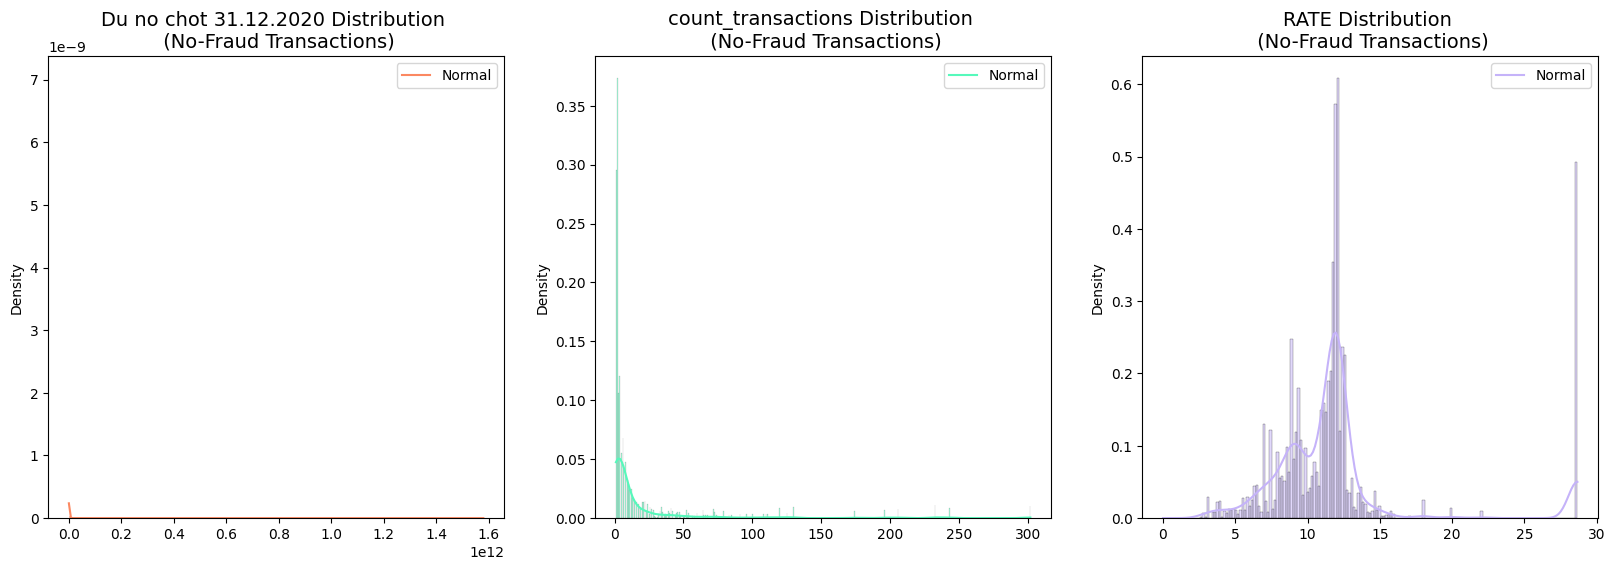

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = business_cif['Du no chot 31.12.2020'].loc[business_cif['CIFMAX'] == 0].values
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, stat="density", color='#FB8861', line_kws={'label': 'Normal'})
ax1.set_title('Du no chot 31.12.2020 Distribution \n (No-Fraud Transactions)', fontsize=14)
ax1.legend()

v12_fraud_dist = business_cif['count_transactions'].loc[business_cif['CIFMAX'] == 0].values
sns.histplot(v12_fraud_dist, ax=ax2, kde=True, stat="density", color='#56F9BB', line_kws={'label': 'Normal'})
ax2.set_title('count_transactions Distribution \n (No-Fraud Transactions)', fontsize=14)
ax2.legend()

v10_fraud_dist = business_cif['RATE'].loc[business_cif['CIFMAX'] == 0].values
sns.histplot(v10_fraud_dist, ax=ax3, kde=True, stat="density", color='#C5B3F9', line_kws={'label': 'Normal'})
ax3.set_title('RATE Distribution \n (No-Fraud Transactions)', fontsize=14)
ax3.legend()

plt.show()


In [ ]:
business_cif = remove_outliers(business_cif, 'Du no chot 31.12.2020')

Số dòng đã bị xóa: 201


In [ ]:
business_cif = remove_outliers(business_cif, 'Dự phòng cụ thể  phải trích đến 31/12/2020')


Số dòng đã bị xóa: 124


In [ ]:
business_cif = remove_outliers(business_cif, 'Du thu ton')

Số dòng đã bị xóa: 172


In [ ]:
# Lấy logarit tự nhiên cho 2 trường có skewness của kurtosis cao sat khi loại bỏ outlier
business_cif['lnDu_no_chot'] = np.log(business_cif['Du no chot 31.12.2020'])
business_cif['lnDu_phong_chot'] = np.log(business_cif['Dự phòng cụ thể  phải trích đến 31/12/2020'])
business_cif['lnDu_phong_chot'].replace(-np.inf, 0, inplace=True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Áp dụng Robust Scaler cho các trường có nhiều outlier nhưng không muốn loại bỏ
scaler = RobustScaler()
business_cif[['Giá trị đảm bảo', 'Du thu ton']] = scaler.fit_transform(business_cif[['Giá trị đảm bảo', 'Du thu ton']])

In [ ]:
X = business_cif[['MIS_CODE', 'RATE', 'Du thu ton', 'LOANTYPE', 'CIC', 'ODIP', 'CARD', 'count_transactions', 'lnDu_no_chot',
                    'lnDu_phong_chot', 'Giá trị đảm bảo', 'Năm giải ngân', 'Tỷ lệ nợ ngắn hạn', 'Tỷ lệ nợ dài hạn']]
y = business_cif['CIFMAX']
categorical_columns = X.select_dtypes(include=['object']).columns
# Tạo một transformer để one-hot encode các cột chuỗi
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Giữ lại các cột số không bị chuyển đổi
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
# Áp dụng SMOTE cho dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Original dataset shape: {pd.Series(y_train).value_counts()}")
print(f"Resampled dataset shape: {pd.Series(y_resampled).value_counts()}")

Original dataset shape: CIFMAX
0    37108
1      510
Name: count, dtype: int64
Resampled dataset shape: CIFMAX
0    37108
1    37108
Name: count, dtype: int64


Random Forest Classifier has a test accuracy score of 99.51%
Recall: 99.51%
Precision: 99.63%
F1 Score: 99.55%
                          Feature  Importance
42     remainder__lnDu_phong_chot    0.449360
39          remainder__Du thu ton    0.228306
37        cat__Năm giải ngân_2020    0.038773
40  remainder__count_transactions    0.033860
12                   cat__CIC_0.0    0.031727
38                remainder__RATE    0.029327
16                   cat__CIC_4.0    0.024956
15                   cat__CIC_3.0    0.021115
41        remainder__lnDu_no_chot    0.015581
17                   cat__CIC_5.0    0.012998
11             cat__LOANTYPE_NORM    0.012155
10            cat__LOANTYPE_COVID    0.010062
1          cat__MIS_CODE_110000.0    0.008934
21                  cat__CARD_1.0    0.008888
43     remainder__Giá trị đảm bảo    0.008852
13                   cat__CIC_1.0    0.008345
22                  cat__CARD_2.0    0.008320
36        cat__Năm giải ngân_2019    0.005604
35        cat__

<Axes: xlabel='Feature'>

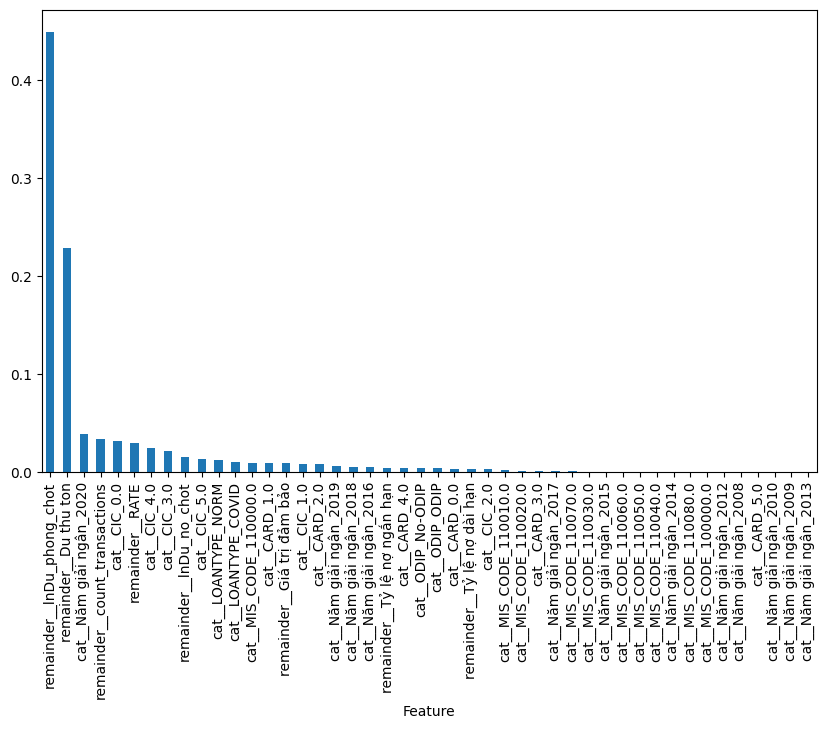

In [ ]:
# Extract feature names after one-hot encoding and passthrough
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Train the Random Forest model
random_forest = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42
)
random_forest.fit(X_resampled, y_resampled)
y_pred = random_forest.predict(X_test_preprocessed)

# Calculate accuracy, recall, precision, and F1 score for the test dataset
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred, average='weighted')
test_precision = precision_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Random Forest Classifier has a test accuracy score of {round(test_accuracy * 100, 2)}%")
print(f"Recall: {round(test_recall * 100, 2)}%")
print(f"Precision: {round(test_precision * 100, 2)}%")
print(f"F1 Score: {round(test_f1 * 100, 2)}%")

# Calculate feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))


Nhận xét cho KH Doanh nghiệp:
- Số tiền dự phòng: Đây là một yếu tố quan trọng vì nó phản ánh mức độ rủi ro tín dụng của các khoản vay. Các khoản vay có rủi ro cao đòi hỏi lượng dự phòng lớn, ảnh hưởng trực tiếp đến sức khỏe tài chính của ngân hàng và khả năng xử lý nợ xấu.
- Năm giải ngân 2020: Năm 2020 là thời điểm đặc biệt khó khăn do đại dịch COVID-19. Việc giải ngân trong năm này có thể gặp nhiều rủi ro hơn do tình hình kinh tế bất ổn, dẫn đến việc phân loại và dự phòng cho các khoản vay trở nên phức tạp hơn, ảnh hưởng lớn đến kết quả dự đoán.
- Dự thu tồn: Khoản lãi chưa thu được là chỉ số phản ánh khả năng khách hàng không hoàn thành nghĩa vụ tài chính. Số tiền này càng lớn, rủi ro cho ngân hàng càng cao, làm tăng tầm quan trọng của biến này trong dự đoán khả năng nợ xấu.
Rate (Lãi suất vay):: Lãi suất vay trực tiếp ảnh hưởng đến khả năng trả nợ của khách hàng. Lãi suất cao có thể gây khó khăn cho khách hàng trong việc trả nợ, do đó, biến này có tác động đáng kể đến việc đánh giá rủi ro tín dụng.
- count transactions (Tổng số khoản vay): Số lượng khoản vay của khách hàng phản ánh mức độ tín nhiệm và mức độ sử dụng dịch vụ của khách hàng tại ngân hàng. Số lượng khoản vay càng nhiều có thể cho thấy sự phức tạp và rủi ro tổng thể của hồ sơ tín dụng, ảnh hưởng đến đánh giá tổng thể về khả năng vỡ nợ.

Random Forest Classifier with adjusted threshold 0.7:
Test Accuracy: 97.87%
Recall: 97.87%
Precision: 98.42%
F1 Score: 98.02%
                          Feature  Importance
36     remainder__lnDu_phong_chot    0.433594
33          remainder__Du thu ton    0.328498
32                remainder__RATE    0.032928
35        remainder__lnDu_no_chot    0.028536
34  remainder__count_transactions    0.025375
8                    cat__CIC_3.0    0.022064
30        cat__Năm giải ngân_2019    0.015996
39    remainder__Tỷ lệ nợ dài hạn    0.011397
5                    cat__CIC_0.0    0.010686
37     remainder__Giá trị đảm bảo    0.010627
31        cat__Năm giải ngân_2020    0.010272
9                    cat__CIC_4.0    0.009353
7                    cat__CIC_2.0    0.008718
17                  cat__CARD_4.0    0.008609
14                  cat__CARD_1.0    0.008285
6                    cat__CIC_1.0    0.005528
13                  cat__CARD_0.0    0.004901
4              cat__LOANTYPE_NORM    0.004731


<Axes: xlabel='Feature'>

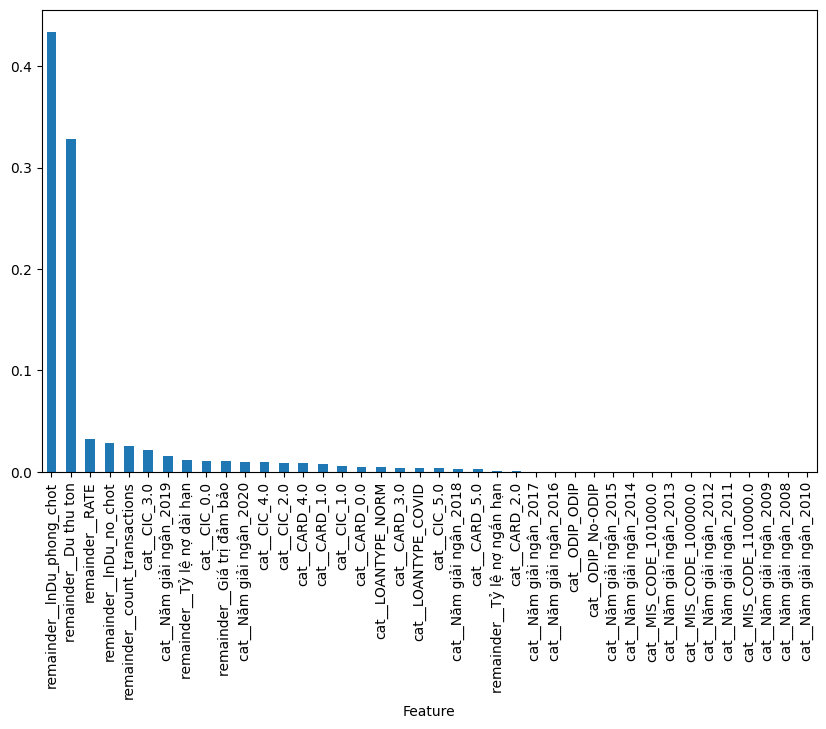

In [ ]:
# Extract feature names after one-hot encoding and passthrough
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

random_forest = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42
)

random_forest.fit(X_resampled, y_resampled)
y_prob = random_forest.predict_proba(X_test_preprocessed)

# Thay đổi ngưỡng thành 0.3 để tăng recall
threshold = 0.7
y_pred_adjusted = (y_prob[:, 1] >= threshold).astype(int)

# Tính toán accuracy, recall, precision, và F1 score cho bộ dữ liệu kiểm tra với ngưỡng mới
test_accuracy = accuracy_score(y_test, y_pred_adjusted)
test_recall = recall_score(y_test, y_pred_adjusted, average='weighted')
test_precision = precision_score(y_test, y_pred_adjusted, average='weighted')
test_f1 = f1_score(y_test, y_pred_adjusted, average='weighted')

print(f"Random Forest Classifier with adjusted threshold {threshold}:")
print(f"Test Accuracy: {round(test_accuracy * 100, 2)}%")
print(f"Recall: {round(test_recall * 100, 2)}%")
print(f"Precision: {round(test_precision * 100, 2)}%")
print(f"F1 Score: {round(test_f1 * 100, 2)}%")


# Calculate feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))


Nhận xét cho KH cá nhân:
- Lượng tiền dự phòng phải trích: Biến này đứng đầu vì nó phản ánh mức độ rủi ro của khoản vay. Khi một khoản vay có rủi ro lớn, ngân hàng phải trích lập dự phòng nhiều hơn để đề phòng tình huống vỡ nợ, do đó ảnh hưởng mạnh đến khả năng phân loại và dự đoán nợ xấu.
- Dự thu tồn: Tiền lãi chưa thu được từ khách hàng là một dấu hiệu của rủi ro tín dụng. Nếu số tiền này lớn, khả năng khách hàng không hoàn thành nghĩa vụ trả nợ cũng cao, làm tăng rủi ro cho ngân hàng, do đó biến này có tầm quan trọng đáng kể.
- Rate (Lãi suất vay): Lãi suất vay cao có thể gây khó khăn cho khách hàng trong việc trả nợ, đặc biệt trong điều kiện kinh tế khó khăn. Điều này làm tăng rủi ro cho ngân hàng, vì vậy lãi suất vay là một yếu tố quan trọng trong dự đoán rủi ro.
- lnDu_no_chot (Dư nợ chốt): Dư nợ chốt phản ánh tổng số nợ mà khách hàng còn phải trả tại thời điểm chốt sổ. Tổng dư nợ lớn có thể chỉ ra rủi ro cao hơn, đặc biệt nếu khả năng trả nợ của khách hàng không được đảm bảo, do đó biến này có tầm quan trọng lớn trong mô hình.
- count_transactions (Tổng số khoản vay của khách hàng): Số lượng khoản vay phản ánh mức độ tín nhiệm và khả năng sử dụng dịch vụ của khách hàng tại ngân hàng. Số lượng giao dịch lớn có thể làm tăng rủi ro tổng thể, đặc biệt nếu khách hàng có nhiều khoản vay rủi ro, nên biến này cũng ảnh hưởng đáng kể.
- CIC (Thông tin tín dụng khách hàng): CIC liên quan đến hồ sơ tín dụng của khách hàng, cung cấp thông tin về khả năng trả nợ trong quá khứ và rủi ro tiềm ẩn. Thông tin này rất quan trọng để dự đoán khả năng vỡ nợ, do đó CIC cũng là một trong những biến quan trọng.